<div>
<img src="https://blogs.qub.ac.uk/wp-content/uploads/2018/05/qub_logo_land.png" width="200", align="left">
</div>

Code used for Chapter 4 should be placed in this notebook. Please explain your thought process / interpretation of plots where you think it would be useful by using Markdown cells.

*Before using this notebook, please read [Jupyter Notebook 101](https://www.kaggle.com/code/jhoward/jupyter-notebook-101)*. 

Student Name: Benjamin Graham
Student Number: 40038234

# Chapter 4

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.stats import gaussian_kde

## 4.1 Format data into a more analysable form

The first thing to do is read the CSV files and assign them to DataFrames. Since there are 5 different datasets for 5 different UK supermarkets, I will then contatenate them together to form one very large dataset.

In [10]:
# Read CSV files
aldi_df = pd.read_csv('All_Data_Aldi.csv')
asda_df = pd.read_csv('All_Data_ASDA.csv', low_memory=False)
morrisons_df = pd.read_csv('All_Data_Morrisons.csv')
sainsburys_df = pd.read_csv('All_Data_Sains.csv')
tesco_df = pd.read_csv('All_Data_Tesco.csv')

In [252]:
# Concatenate DataFrames
df = pd.concat([aldi_df, asda_df, morrisons_df, sainsburys_df, tesco_df])

# Check each supermarket has been added
df['supermarket'].unique()

array(['Aldi', 'ASDA', 'Morrisons', 'Sains', 'Tesco'], dtype=object)

In [253]:
df.shape

(9529242, 8)

In [254]:
df.head()

,supermarket,prices_(£),prices_unit_(£),unit,names,date,category,own_brand
0,Aldi,3.09,0.14,unit,Mamia Ultra-fit Peppa Pig Nappy Pants 22 Pack/...,20240413,baby_products,False
1,Aldi,3.09,0.17,unit,Mamia Ultra-fit Peppa Pig Nappy Pants 18 Pack/...,20240413,baby_products,False
2,Aldi,3.59,0.09,unit,Mamia Ultra-fit Nappy Pants 40 Pack/Size 4,20240413,baby_products,False
3,Aldi,4.79,0.32,unit,Mamia Boy's Night Pants 15 Pack,20240413,baby_products,False
4,Aldi,4.79,0.32,unit,Mamia Girl's Night Pants 15 Pack,20240413,baby_products,False


As you can see, the datasets have been successfully concatenated. This is confirmed by the unique function, which returns the 5 unique values in the 'supermarket' column: Aldi, ASDA, Morrisons, Sainsburys and Tesco. 

The dataset is now very large, with nearly 10 million rows and 8 columns. I will consider ways to make the dataset smaller, as it will effect how long it takes to produce the necessary visualisations in later sections in this chapter, as well as chapter 5.

For now, however, I will standardise the column names, handle null values, convert certain columns to more appropriate data types and remove duplicates.

In [255]:
print('Original column names:\n')
df.columns

Original column names:



Index(['supermarket', 'prices_(£)', 'prices_unit_(£)', 'unit', 'names', 'date',
       'category', 'own_brand'],
      dtype='object')

In [256]:
# Standardise column names
df.columns = ['supermarket', 'price', 'price_per_unit', 'unit', 'product_name', 'date', 'category', 'own_brand']

print('Standardised column names:\n')
df.columns

Standardised column names:



Index(['supermarket', 'price', 'price_per_unit', 'unit', 'product_name',
       'date', 'category', 'own_brand'],
      dtype='object')

In [257]:
# Identify null or empty values
null_values = df.isnull().sum()
print('Null values count before cleaning:\n')
null_values

Null values count before cleaning:



supermarket         0
price               7
price_per_unit    524
unit              524
product_name       26
date                0
category            0
own_brand          26
dtype: int64

In [258]:
# Remove nulls for less significant columns
df = df.dropna(subset=['price', 'product_name', 'own_brand']).copy()

# Fill nulls with placeholders for more significant columns
df['price_per_unit'] = df['price_per_unit'].fillna(0)
df['unit'] = df['unit'].fillna('unit')

# Check null or empty values have been handled
null_values = df.isnull().sum()
print('Null values count after cleaning:\n')
print(null_values)

Null values count after cleaning:

supermarket       0
price             0
price_per_unit    0
unit              0
product_name      0
date              0
category          0
own_brand         0
dtype: int64


In [259]:
# Display data types for each column
print('Original data types:\n')
df.dtypes

Original data types:



supermarket        object
price             float64
price_per_unit    float64
unit               object
product_name       object
date                int64
category           object
own_brand          object
dtype: object

In [260]:
# Convert 'date' column to datetime data type
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')

# Handle mixed data types for 'own_brand' column by converting from object to Boolean
df['own_brand'] = df['own_brand'].astype(bool)
                                                                           
# Check data types have been updated
print('Updated data types:')
df.dtypes

Updated data types:


supermarket               object
price                    float64
price_per_unit           float64
unit                      object
product_name              object
date              datetime64[ns]
category                  object
own_brand                   bool
dtype: object

In [261]:
# Check for both True/False values in ASDA rows
check_asda_bools = df.loc[df['supermarket'] == 'ASDA']
check_asda_bools.head()

,supermarket,price,price_per_unit,unit,product_name,date,category,own_brand
0,ASDA,4.75,19.8,kg,Tassimo Cadbury Hot Chocolate Pods x 8,2024-04-13,drinks,False
1,ASDA,2.00,26.7,kg,Taylors of Harrogate Hot Lava Java Coffee Bags,2024-04-13,drinks,False
2,ASDA,5.00,20.8,kg,Tassimo Limited Edition Cadbury Orange Hot Cho...,2024-04-13,drinks,False
3,ASDA,3.50,15.4,kg,ASDA Extra Special Brazilian Ground Coffee,2024-04-13,drinks,True
4,ASDA,3.50,15.4,kg,ASDA Extra Special Espresso Coffee Beans,2024-04-13,drinks,True


In [262]:
# Identify duplicate rows
duplicates = df.duplicated()
print('Number of duplicated rows before cleaning: ', duplicates.sum())

Number of duplicated rows before cleaning:  23828


In [263]:
# Remove duplicates
df = df.drop_duplicates()

# Check duplicates have been removed
duplicates = df.duplicated()
print('Number of duplicated rows after cleaning: ', duplicates.sum())

Number of duplicated rows after cleaning:  0


To optimise the performance and efficiency of my data analysis, I will use a methodical approach to reduce the dataset size while maintaining its representativeness. First, I will create a pivot table that summarises the number of rows for each supermarket on each date the data was collected. This pivot table will provide a clear overview of the dataset’s distribution over time for each supermarket, enabling a more comprehensive understanding of data patterns.

In [264]:
# Create pivot table to calculate the number of rows per date for each supermarket
number_of_rows_per_date = df.pivot_table(
    values = 'product_name',
    index = 'supermarket',
    columns = 'date',
    aggfunc = 'count'
)

number_of_rows_per_date = number_of_rows_per_date.fillna(0).astype(int)

number_of_rows_per_date

date,2024-01-09,2024-01-10,2024-01-11,2024-01-12,2024-01-13,2024-01-14,2024-01-15,2024-01-16,2024-01-17,2024-01-18,...,2024-04-04,2024-04-05,2024-04-06,2024-04-07,2024-04-08,2024-04-09,2024-04-10,2024-04-11,2024-04-12,2024-04-13
supermarket,,,,,,,,,,,,,,,,,,,,,
ASDA,24796,24770,24918,25316,25495,25842,25605,25981,25417,25940,...,27786,27791,27677,27534,27770,27707,27694,27765,27783,27824
Aldi,4792,5008,4934,4884,4884,4879,4973,4964,4958,4963,...,5174,5244,5301,5295,5269,5284,5119,5114,5113,5112
Morrisons,18345,17830,19906,15850,17203,20248,18974,20267,18104,16616,...,18109,18109,18151,18060,18214,18213,7543,18143,18129,18098
Sains,28146,28166,28084,28059,28103,28180,28188,28108,28134,27695,...,28247,28077,27939,27902,27910,26766,28028,27048,27878,28019
Tesco,23397,23932,23897,23878,24043,0,23828,24071,24260,24316,...,25662,25611,25690,25615,25651,25652,25738,25734,25669,24461


As observed, the number of rows for each supermarket — corresponding to the number of products on sale — remains relatively consistent across different dates, indicating that the product ranges do not vary significantly from day to day. This consistency suggests that I can reliably average the number of rows per supermarket without compromising the data's integrity.

Therefore, using a pivot table, I will calculate the average number of rows per day for each supermarket. This step is crucial as it helps identify what constitutes a typical day's data for each supermarket. With these averages, I will then identify the date for each supermarket that most closely approximates the average number of rows. Selecting these representative dates ensures that the data used is reflective of typical activity, thus preserving the integrity of the analysis.

In [265]:
average_rows_per_day = number_of_rows_per_date.mean(axis=1)
average_rows_per_day.astype(int)

supermarket
ASDA         26699
Aldi          5052
Morrisons    19500
Sains        28264
Tesco        23801
dtype: int64

In [266]:
difference_from_average = number_of_rows_per_date.sub(average_rows_per_day, axis=0).abs()
closest_dates = difference_from_average.idxmin(axis=1)
closest_dates

supermarket
ASDA        2024-01-25
Aldi        2024-03-05
Morrisons   2024-01-26
Sains       2024-04-01
Tesco       2024-03-28
dtype: datetime64[ns]

Next, I will filter the original dataset to include only the rows from these selected representative dates for each supermarket. This significantly reduces the dataset's size, making it more manageable and less resource-intensive. By focusing on these representative data points, I can perform subsequent analyses and visualisations more efficiently, benefiting from the reduced computational load while still drawing meaningful insights.

In [267]:
df = df.loc[
    ((df['supermarket'] == 'ASDA') & (df['date'] == pd.to_datetime('2024-01-25'))) |
    ((df['supermarket'] == 'Aldi') & (df['date'] == pd.to_datetime('2024-03-05'))) |
    ((df['supermarket'] == 'Morrisons') & (df['date'] == pd.to_datetime('2024-01-26'))) |
    ((df['supermarket'] == 'Sains') & (df['date'] == pd.to_datetime('2024-04-01'))) |
    ((df['supermarket'] == 'Tesco') & (df['date'] == pd.to_datetime('2024-03-28')))
]

df['date'].unique()

<DatetimeArray>
['2024-03-05 00:00:00', '2024-01-25 00:00:00', '2024-01-26 00:00:00',
 '2024-04-01 00:00:00', '2024-03-28 00:00:00']
Length: 5, dtype: datetime64[ns]

This method has some potential setbacks. One limitation is that by focusing on a single representative date for each supermarket, I might overlook daily variations and trends that could be important for certain analyses. Additionally, if there are any anomalies or unusual events on the selected dates, they could skew the results. Despite these limitations, this approach enables efficient and accurate analysis by honing in on data that best represents typical conditions, thus ensuring that the insights derived are both meaningful and computationally manageable.

Let's remove the 'date' column, as it is not relevant to our analysis.

In [268]:
df = df.drop(columns=['date'])
df.head()

,supermarket,price,price_per_unit,unit,product_name,category,own_brand
193384,Aldi,1.69,0.37,kg,Plant Menu Vegetable Burgers 454g/4 Pack,free-from,False
193385,Aldi,1.69,0.37,kg,Plant Menu Spicy Bean Burgers 454g/4 Pack,free-from,False
193386,Aldi,1.69,3.70,kg,Plant Menu No Chicken Burgers 227g/2 Pack,free-from,False
193387,Aldi,1.69,7.40,kg,Veggie Menu Bean & Vegetable Burgers 227g/2 Pack,free-from,False
193388,Aldi,1.49,3.70,kg,Plant Menu No Chicken Pies 2x200g,free-from,False


Next, I will add a customer satisfaction metric score for each supermarket to the dataset. This score is taken from the annual Which? supermarket satisfaction survey, as it represents the most reliable publicly available customer satisfaction metric, allowing for comparison between the supermarkets in this dataset (https://www.which.co.uk/news/article/which-reveals-the-best-and-worst-supermarkets-of-2024-ajJmU0r1g98S).

In [270]:
# Add customer satisfaction scores to the dataset
which_customer_scores = {
    'Aldi': 73,
    'ASDA': 64,
    'Morrisons': 64,
    'Sains': 70,
    'Tesco': 70
}
if 'customer_satisfaction' not in df.columns:
    df['customer_satisfaction'] = df['supermarket'].map(which_customer_scores)

df.head()

,supermarket,price,price_per_unit,unit,product_name,category,own_brand,customer_satisfaction
193384,Aldi,1.69,0.37,kg,Plant Menu Vegetable Burgers 454g/4 Pack,free-from,False,73
193385,Aldi,1.69,0.37,kg,Plant Menu Spicy Bean Burgers 454g/4 Pack,free-from,False,73
193386,Aldi,1.69,3.70,kg,Plant Menu No Chicken Burgers 227g/2 Pack,free-from,False,73
193387,Aldi,1.69,7.40,kg,Veggie Menu Bean & Vegetable Burgers 227g/2 Pack,free-from,False,73
193388,Aldi,1.49,3.70,kg,Plant Menu No Chicken Pies 2x200g,free-from,False,73


In [271]:
# Check each value has been added for each supermarket (ASDA and Morrisons/Sains and Tesco have same scores)
df['customer_satisfaction'].unique()

array([73, 64, 70])

Now I will calculate aggregate statistics for the total number of products, the total number of own brand products, the average price, and the average price of own brand products for each supermarket. This will help in future analysis, particularly when normalising the data in section 4.3. 

In [272]:
average_own_brand_price = df[df['own_brand']].groupby('supermarket')['price'].mean().reset_index().round(2)
average_own_brand_price = average_own_brand_price.rename(columns={'price': 'average_own_brand_price'})

pivot_table = pd.pivot_table(
    df,
    values=['price', 'own_brand', 'product_name'],
    index='supermarket',
    aggfunc={
        'product_name': 'count',
        'own_brand': 'sum',
        'price': 'mean'
    }
).rename(columns={
    'product_name': 'total_products',
    'own_brand': 'total_own_brand_products',
    'price': 'average_price'
}).reset_index()

pivot_table['average_price'] = pivot_table['average_price'].round(2)

pivot_table = pivot_table.merge(average_own_brand_price, on='supermarket', how='left')

desired_order = ['Aldi', 'ASDA', 'Morrisons', 'Sains', 'Tesco']
pivot_table = pivot_table.set_index('supermarket').reindex(desired_order).reset_index()

pivot_table = pivot_table[['supermarket', 'total_products', 'total_own_brand_products', 'average_price', 'average_own_brand_price']]

pivot_table

,supermarket,total_products,total_own_brand_products,average_price,average_own_brand_price
0,Aldi,5058,831,2.27,2.60
1,ASDA,26758,7894,5.75,4.38
2,Morrisons,19725,4798,5.09,3.88
3,Sains,28263,6401,5.54,3.34
4,Tesco,23820,6280,5.24,3.94


I will now add 'supermarket_total_products' and 'supermarket_total_own_brand_products' to the dataset. I will also rename the column names to make them more understandable. This addition will allow for a comparison with customer satisfaction in Chapter 5, helping to determine if a higher product range correlates with higher customer satisfaction, as well as evaluating the impact of the own brand product range on customer satisfaction.

In [273]:
pivot_table = pivot_table.rename(columns={
    'total_products': 'supermarket_total_products',
    'total_own_brand_products': 'supermarket_total_own_brand_products'
})

pivot_table

,supermarket,supermarket_total_products,supermarket_total_own_brand_products,average_price,average_own_brand_price
0,Aldi,5058,831,2.27,2.60
1,ASDA,26758,7894,5.75,4.38
2,Morrisons,19725,4798,5.09,3.88
3,Sains,28263,6401,5.54,3.34
4,Tesco,23820,6280,5.24,3.94


In [274]:
if 'supermarket_total_products' not in df.columns:
    df = df.merge(pivot_table[['supermarket', 'supermarket_total_products']], on='supermarket', how='left')

df['supermarket_total_products'].unique()

array([ 5058, 26758, 19725, 28263, 23820])

In [275]:
if 'supermarket_total_own_brand_products' not in df.columns:
    df = df.merge(pivot_table[['supermarket', 'supermarket_total_own_brand_products']], on='supermarket', how='left')
    df['supermarket_total_own_brand_products'] = df.apply(
        lambda row: row['supermarket_total_own_brand_products'] if row['own_brand'] else 0, axis=1
    )
df['supermarket_total_own_brand_products'].unique()

array([   0,  831, 7894, 4798, 6401, 6280])

In [299]:
df.head()

,supermarket,price,price_per_unit,unit,product_name,category,own_brand,customer_satisfaction,supermarket_total_products,supermarket_total_own_brand_products
0,Aldi,1.69,0.37,kg,Plant Menu Vegetable Burgers 454g/4 Pack,free-from,False,73,5058,0
1,Aldi,1.69,0.37,kg,Plant Menu Spicy Bean Burgers 454g/4 Pack,free-from,False,73,5058,0
2,Aldi,1.69,3.70,kg,Plant Menu No Chicken Burgers 227g/2 Pack,free-from,False,73,5058,0
3,Aldi,1.69,7.40,kg,Veggie Menu Bean & Vegetable Burgers 227g/2 Pack,free-from,False,73,5058,0
4,Aldi,1.49,3.70,kg,Plant Menu No Chicken Pies 2x200g,free-from,False,73,5058,0


To facilitate visualisation in density plots and histograms for the later sections of this chapter, as well as for Chapter 5, I will convert each categorical string value into its own column using a technique called one-hot encoding. This process involves creating separate columns for each unique value in the 'supermarket' and 'category' columns, with the values represented as 0 or 1. Although the get_dummies function initially converts the string values to booleans, I subsequently converted these to integers. I applied the same conversion to the 'own_brand' column, which was originally represented by boolean values.

In [277]:
df_encoded = pd.get_dummies(df, columns=['supermarket', 'category'], prefix='', prefix_sep='')
boolean_columns = df_encoded.select_dtypes(include='bool').columns
df_encoded[boolean_columns] = df_encoded[boolean_columns].astype(int)
df_encoded.columns = df_encoded.columns.str.lower()
df_encoded.head()

,price,price_per_unit,unit,product_name,own_brand,customer_satisfaction,supermarket_total_products,supermarket_total_own_brand_products,asda,aldi,...,bakery,drinks,food_cupboard,free-from,fresh_food,frozen,health_products,home,household,pets
0,1.69,0.37,kg,Plant Menu Vegetable Burgers 454g/4 Pack,0,73,5058,0,0,1,...,0,0,0,1,0,0,0,0,0,0
1,1.69,0.37,kg,Plant Menu Spicy Bean Burgers 454g/4 Pack,0,73,5058,0,0,1,...,0,0,0,1,0,0,0,0,0,0
2,1.69,3.70,kg,Plant Menu No Chicken Burgers 227g/2 Pack,0,73,5058,0,0,1,...,0,0,0,1,0,0,0,0,0,0
3,1.69,7.40,kg,Veggie Menu Bean & Vegetable Burgers 227g/2 Pack,0,73,5058,0,0,1,...,0,0,0,1,0,0,0,0,0,0
4,1.49,3.70,kg,Plant Menu No Chicken Pies 2x200g,0,73,5058,0,0,1,...,0,0,0,1,0,0,0,0,0,0


Now that the columns have been encoded, I will reorder them to improve readability and export to an Excel file.

In [278]:
# List the one-hot encoded columns for supermarkets
supermarket_columns = ['aldi', 'asda', 'morrisons', 'sains', 'tesco']

# List the one-hot encoded columns for categories (assuming these are known)
category_columns = ['free-from', 'frozen', 'food_cupboard', 'pets', 'fresh_food',
       'baby_products', 'drinks', 'health_products', 'bakery',
       'household', 'home']

# Specify the aggregate columns
aggregate_columns = ['own_brand', 'supermarket_total_products', 'supermarket_total_own_brand_products', 'customer_satisfaction']

# Get other columns that are not one-hot encoded or aggregate columns
other_columns = [col for col in df_encoded.columns if col not in (supermarket_columns + category_columns + aggregate_columns)]

# Combine the columns in the desired order
columns_order = supermarket_columns + other_columns + category_columns + aggregate_columns

# Reorder the dataframe
df_encoded = df_encoded[columns_order]

df_encoded.head()

,aldi,asda,morrisons,sains,tesco,price,price_per_unit,unit,product_name,free-from,...,baby_products,drinks,health_products,bakery,household,home,own_brand,supermarket_total_products,supermarket_total_own_brand_products,customer_satisfaction
0,1,0,0,0,0,1.69,0.37,kg,Plant Menu Vegetable Burgers 454g/4 Pack,1,...,0,0,0,0,0,0,0,5058,0,73
1,1,0,0,0,0,1.69,0.37,kg,Plant Menu Spicy Bean Burgers 454g/4 Pack,1,...,0,0,0,0,0,0,0,5058,0,73
2,1,0,0,0,0,1.69,3.70,kg,Plant Menu No Chicken Burgers 227g/2 Pack,1,...,0,0,0,0,0,0,0,5058,0,73
3,1,0,0,0,0,1.69,7.40,kg,Veggie Menu Bean & Vegetable Burgers 227g/2 Pack,1,...,0,0,0,0,0,0,0,5058,0,73
4,1,0,0,0,0,1.49,3.70,kg,Plant Menu No Chicken Pies 2x200g,1,...,0,0,0,0,0,0,0,5058,0,73


In [279]:
df_encoded.to_csv('supermarkets_encoded.csv', index=False)

## 4.2 Analysis of Univariate Distributions 

To explore the distribution of each variable, I will use the unencoded dataset. This approach is more effective for visualising categorical strings as bar charts and allows for a clearer representation of prices across different supermarkets.

Let's revisit the columns to determine which are worth exploring in detail.

In [280]:
df.columns

Index(['supermarket', 'price', 'price_per_unit', 'unit', 'product_name',
       'category', 'own_brand', 'customer_satisfaction',
       'supermarket_total_products', 'supermarket_total_own_brand_products'],
      dtype='object')

For our analysis, I will explore the distribution of the following columns: 'customer_satisfaction', 'price', 'category' and 'own_brand'.

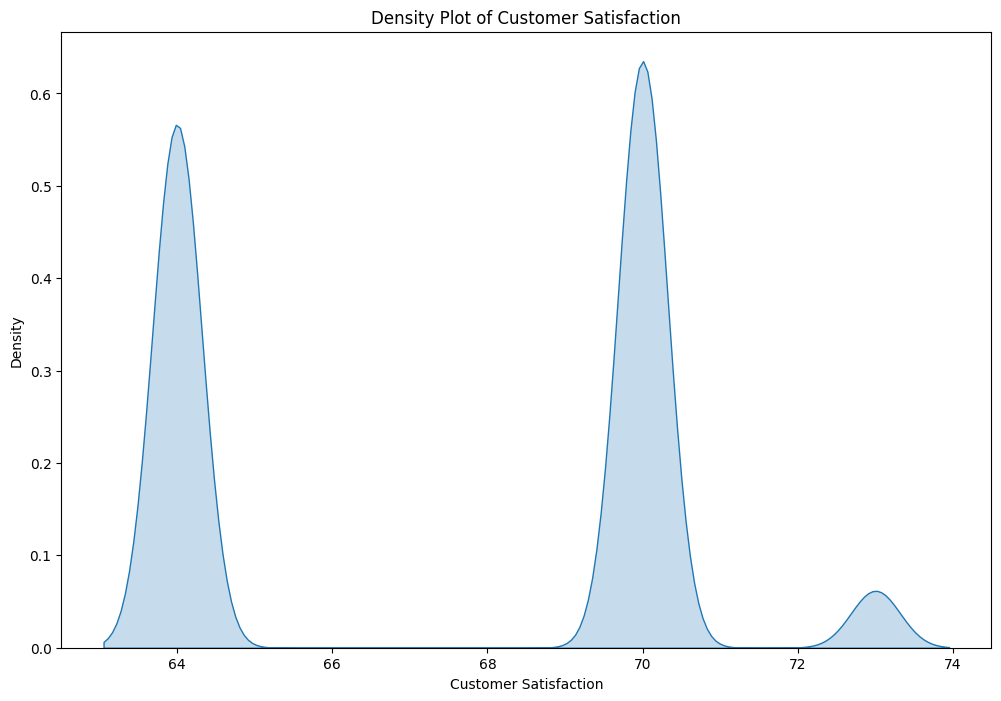

In [281]:
# Create a density plot for the 'price' column
plt.figure(figsize=(12, 8))
sns.kdeplot(data=df, x='customer_satisfaction', fill=True)
plt.title('Density Plot of Customer Satisfaction')
plt.xlabel('Customer Satisfaction')
plt.ylabel('Density')
plt.show()

In the above density plot, the limitations in data points for customer satisfaction is clearly evident, in that the density corresponds to the total number of products for each supermarket. This is because I added customer satisfaction scores for each supermarket as a separate column, meaning each row contains an overall supermarket score. Due to this, the density plot for customer satisfaction is not useful to us right now.

Let's move on to consider the distribution of values in the 'price' columns.

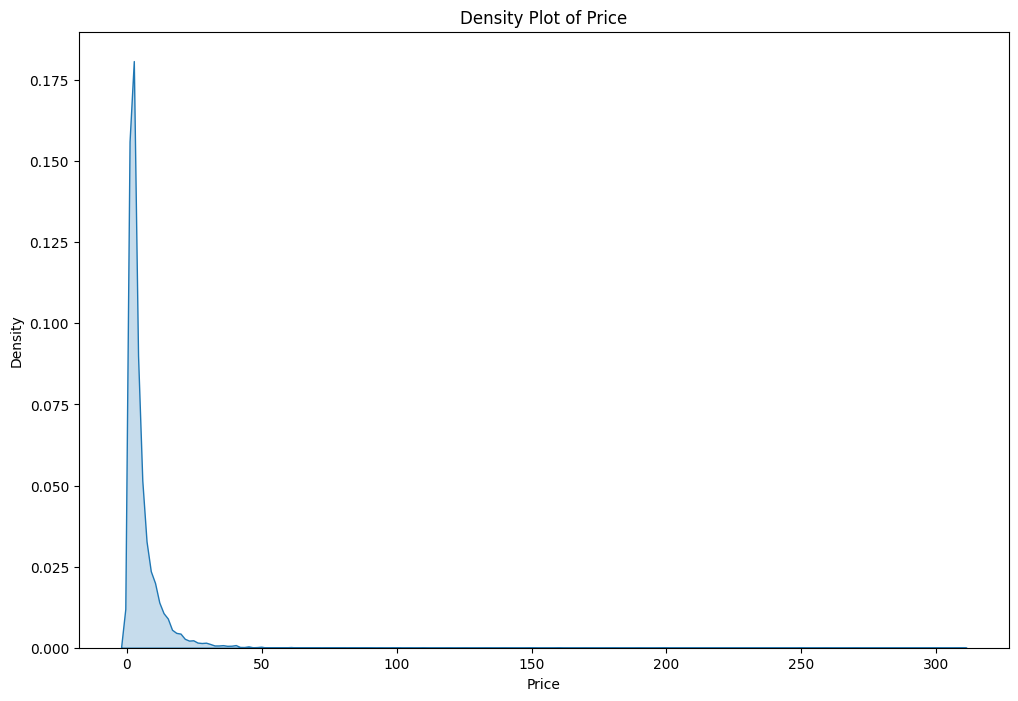

In [282]:
# Create a density plot for the 'price' column
plt.figure(figsize=(12, 8))
sns.kdeplot(data=df, x='price', fill=True)
plt.title('Density Plot of Price')
plt.xlabel('Price')
plt.ylabel('Density')
plt.show()

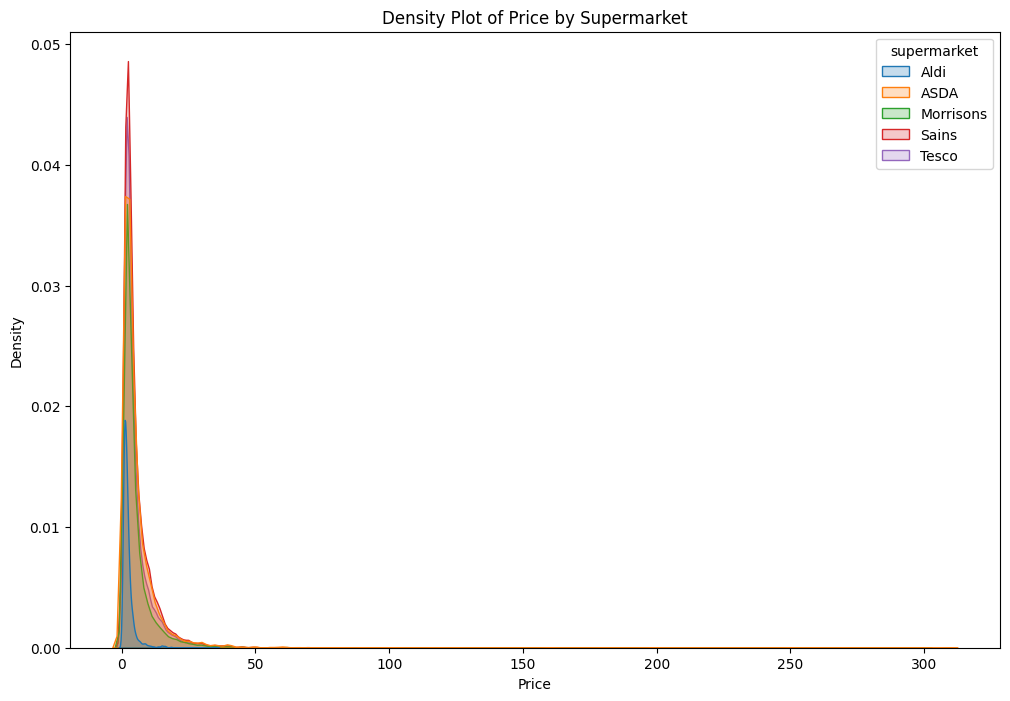

In [283]:
# Create a density plot for the 'price' column with supermarket as hue
plt.figure(figsize=(12, 8))
sns.kdeplot(data=df, x='price', hue='supermarket', fill=True)
plt.title('Density Plot of Price by Supermarket')
plt.xlabel('Price')
plt.ylabel('Density')
plt.show()

As observed, the overall distribution of prices tends to flatline around £50, indicating that the vast majority of products across all supermarkets fall within this range. Aldi is an exception, with prices flattening around £20. This aligns with the findings discussed in Chapter 1, where the differing models between traditional supermarkets (ASDA, Morrisons, Sainsbury's, and Tesco) and the emergence of discount supermarkets (such as Aldi) were explored.

Let's take a closer look by limiting the x-axis to an upper boundary of £50 and, for an even close look, to £20.

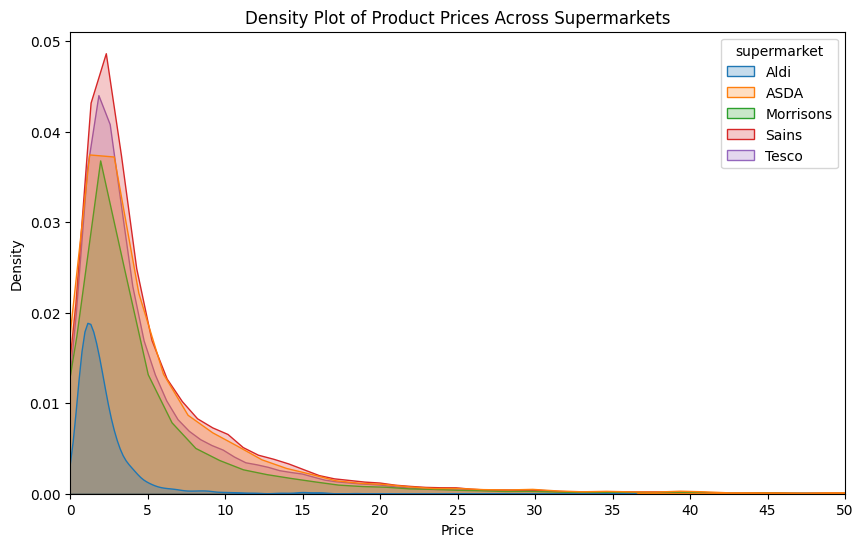

In [284]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df, x='price', hue='supermarket', fill=True)
plt.xlim(0, 50)
plt.xticks(ticks=range(0, 51, 5))
plt.title('Density Plot of Product Prices Across Supermarkets')
plt.xlabel('Price')
plt.ylabel('Density')
plt.savefig('density_plot_prices.png')
plt.show()

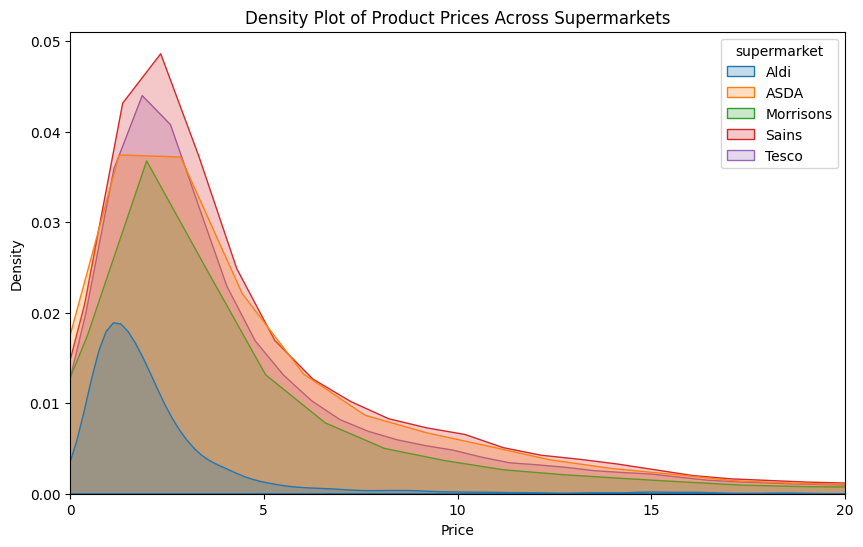

In [285]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df, x='price', hue='supermarket', fill=True)
plt.xlim(0, 20)
plt.xticks(ticks=range(0, 21, 5))
plt.title('Density Plot of Product Prices Across Supermarkets')
plt.xlabel('Price')
plt.ylabel('Density')
plt.show()

The density plot of product prices across different supermarkets reveals distinct patterns in pricing strategies. Overall, the price distribution is right-skewed, with the majority of products priced within a lower range (0 to 10 pounds) and a long tail extending towards higher prices. This indicates a high price sensitivity among consumers, where most prefer more affordable products, while only a few opt for the higher-priced items.

Aldi's distribution stands out with a noticeable peak at a lower price range and flatlining around 20 pounds. This aligns with Aldi's positioning as a discount supermarket, offering a significant number of products at lower prices. This strategy caters to price-sensitive customers looking for value, distinguishing Aldi from traditional supermarkets.

In contrast, the price distributions for ASDA, Morrisons, Sainsbury's and Tesco are quite similar, with peaks around the same price range and tails extending towards higher prices. These similar shapes suggest that these traditional supermarkets have comparable pricing strategies, offering a range of products to meet diverse customer needs. By maintaining a broad pricing strategy, they aim to attract a wide spectrum of consumers, from those seeking value to those willing to pay a premium for specific products.

These findings highlight the competitive landscape among traditional supermarkets, where pricing plays a crucial role in attracting and retaining customers. Aldi's lower pricing strategy clearly differentiates it within the market, potentially capturing a significant share of cost-conscious consumers. Further analysis, such as segmenting the data by product categories or examining the impact of discounts, could provide deeper insights into consumer behavior and the effectiveness of these pricing strategies. Understanding the relationship between price distributions and customer satisfaction could also reveal whether these strategies are meeting customer expectations.

Now let's consider the distribution of prices by product category.

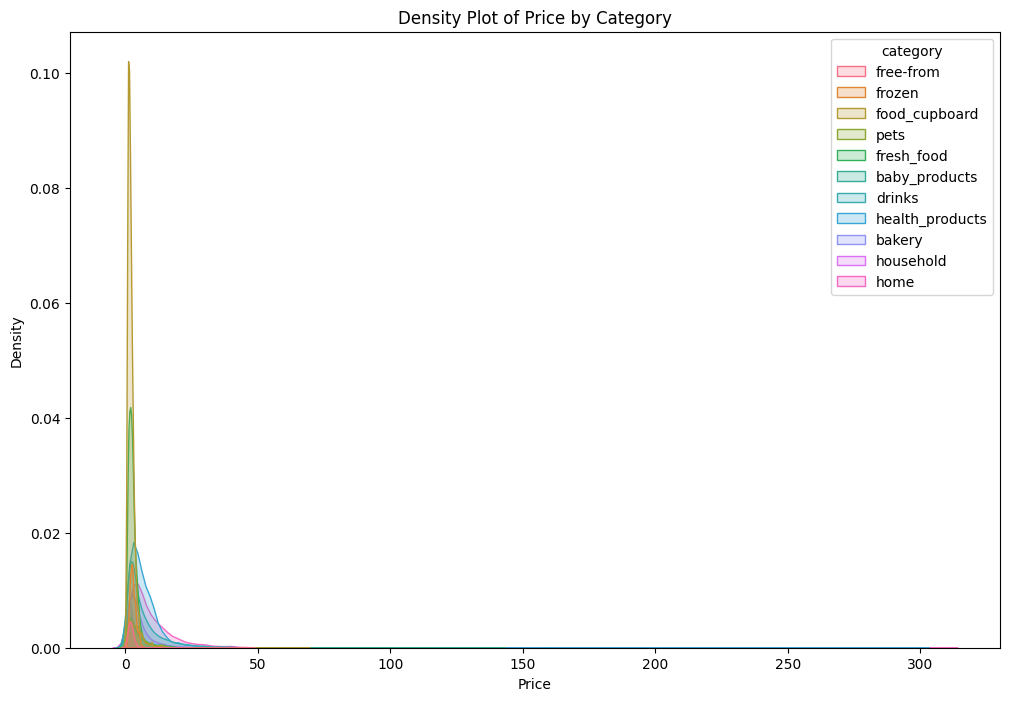

In [286]:
# Create a density plot for the 'price' column with category as hue
plt.figure(figsize=(12, 8))
sns.kdeplot(data=df, x='price', hue='category', fill=True)
plt.title('Density Plot of Price by Category')
plt.xlabel('Price')
plt.ylabel('Density')
plt.show()

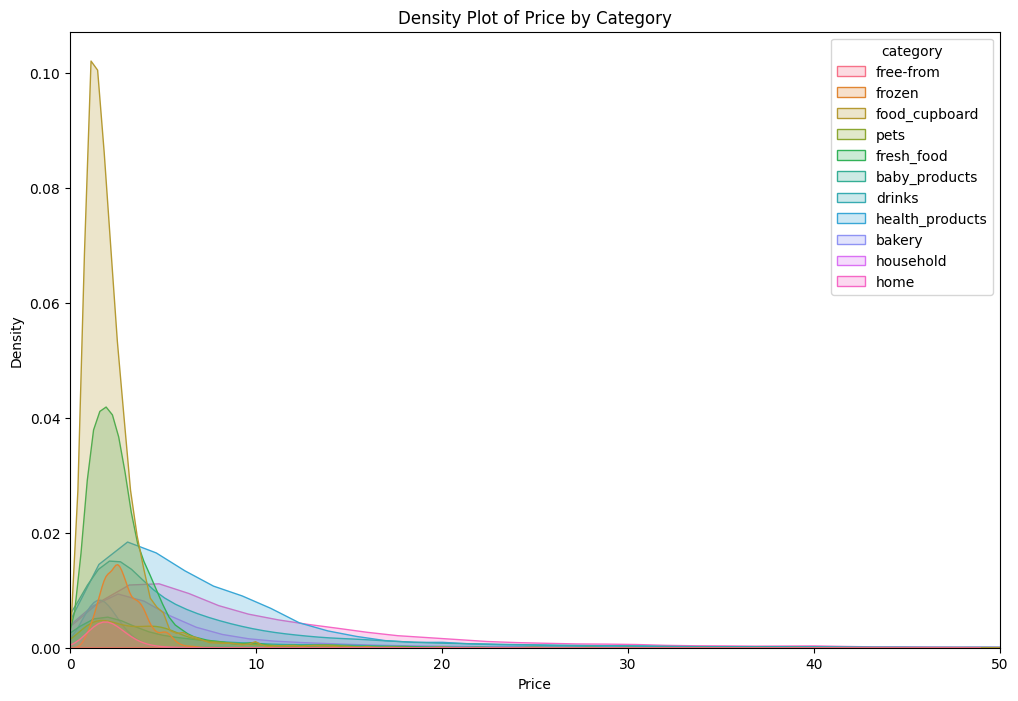

In [287]:
# Create a density plot for the 'price' column with supermarket as hue
plt.figure(figsize=(12, 8))
plt.xlim(0, 50)
sns.kdeplot(data=df, x='price', hue='category', fill=True)
plt.title('Density Plot of Price by Category')
plt.xlabel('Price')
plt.ylabel('Density')
plt.show()

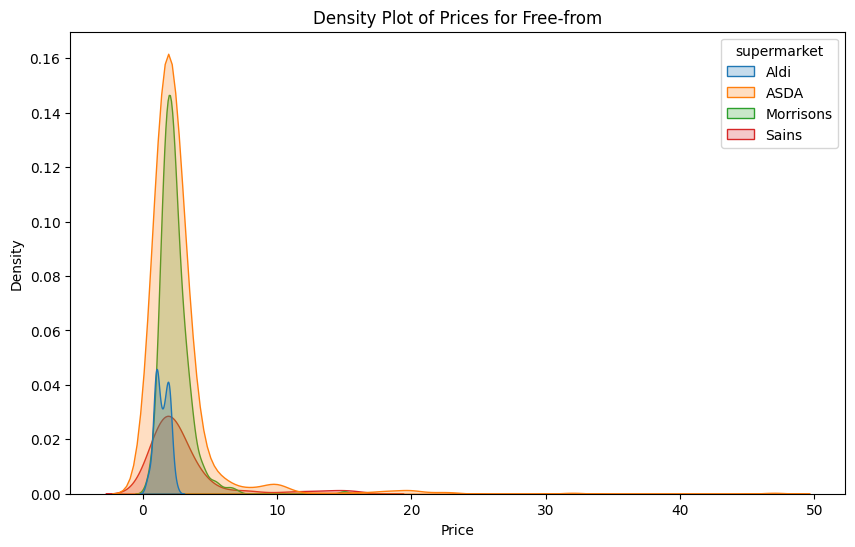

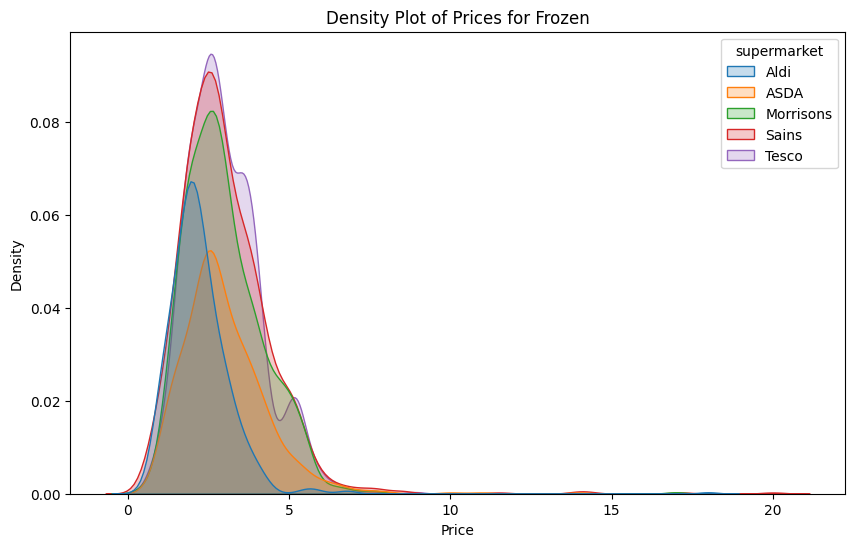

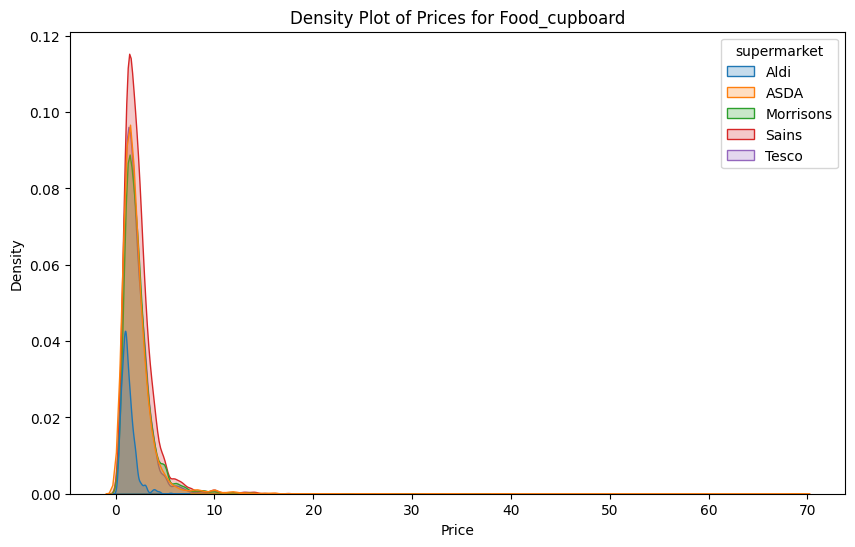

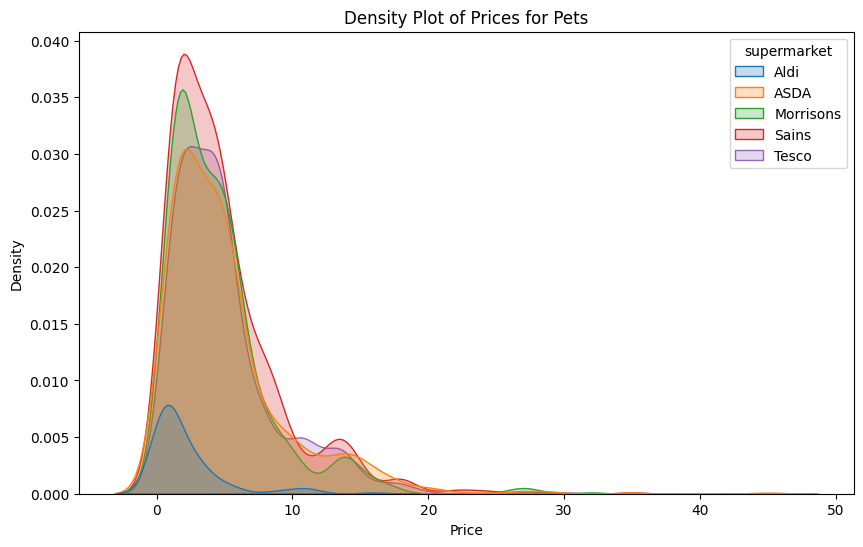

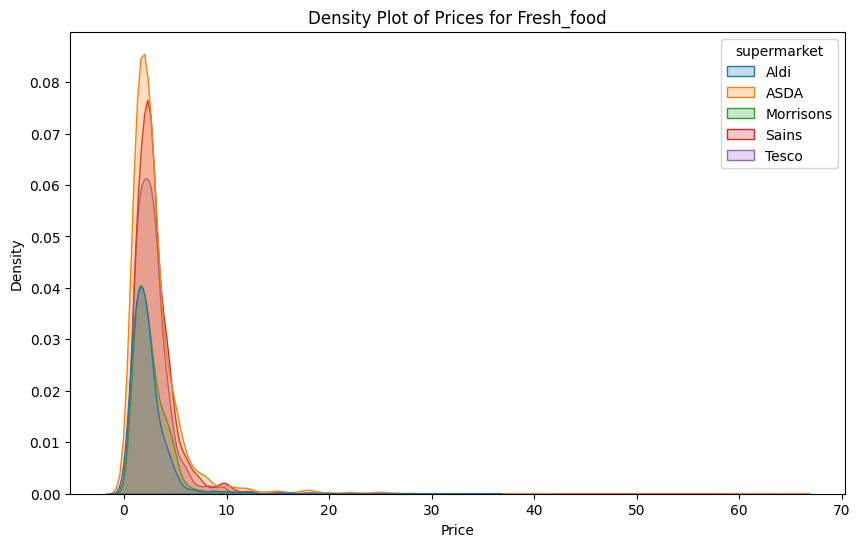

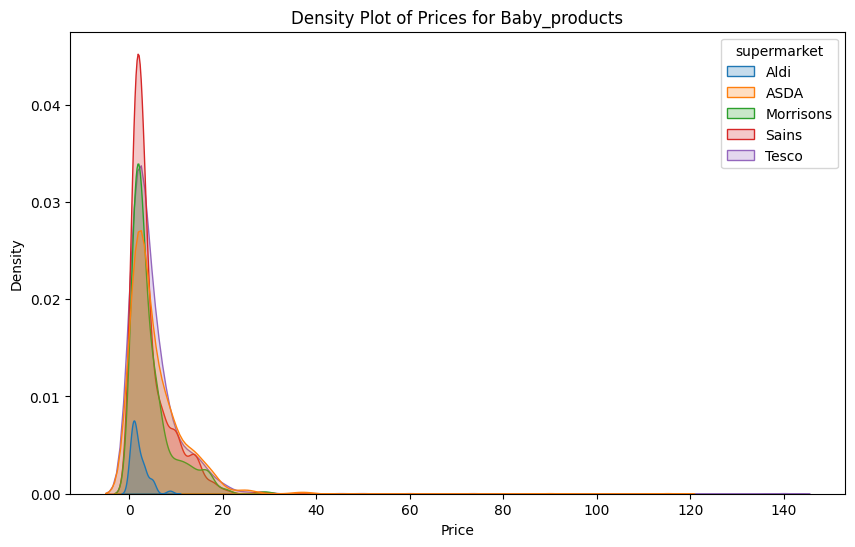

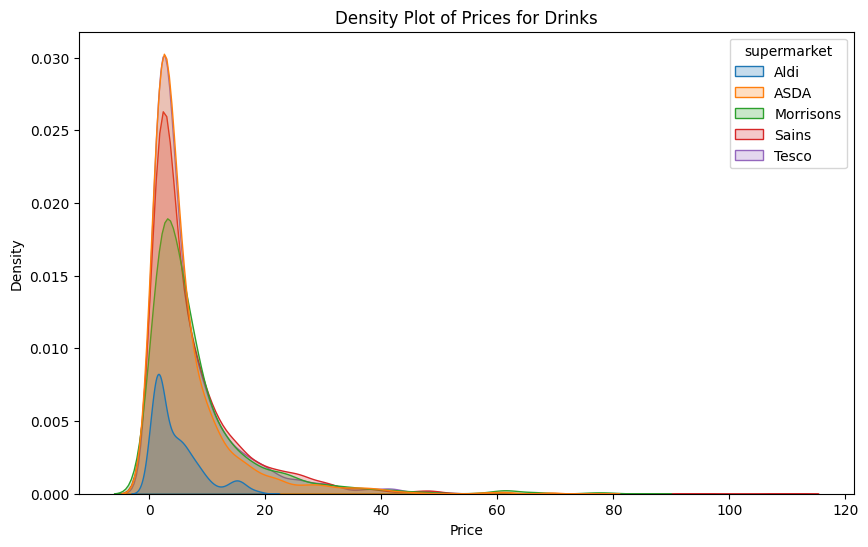

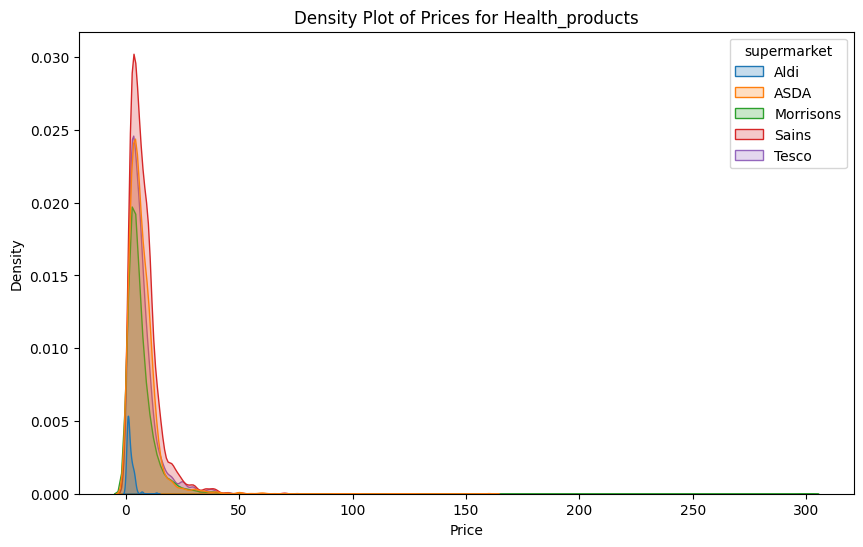

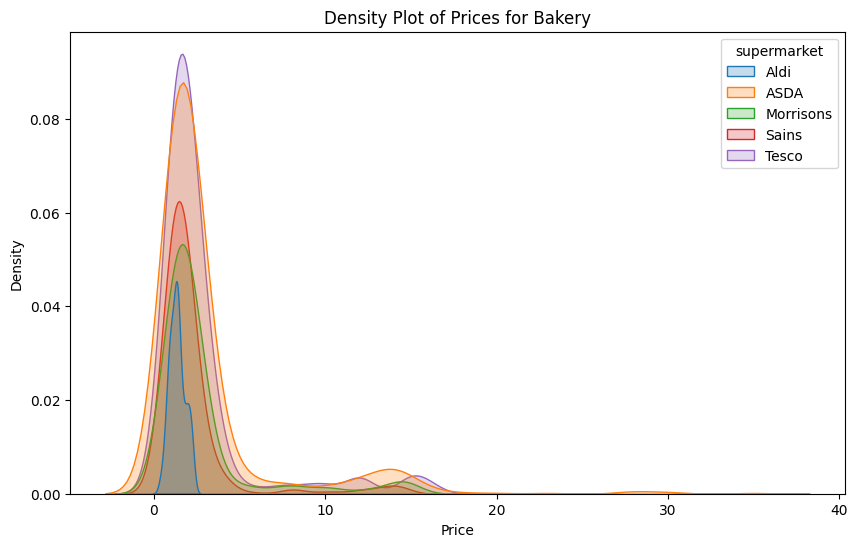

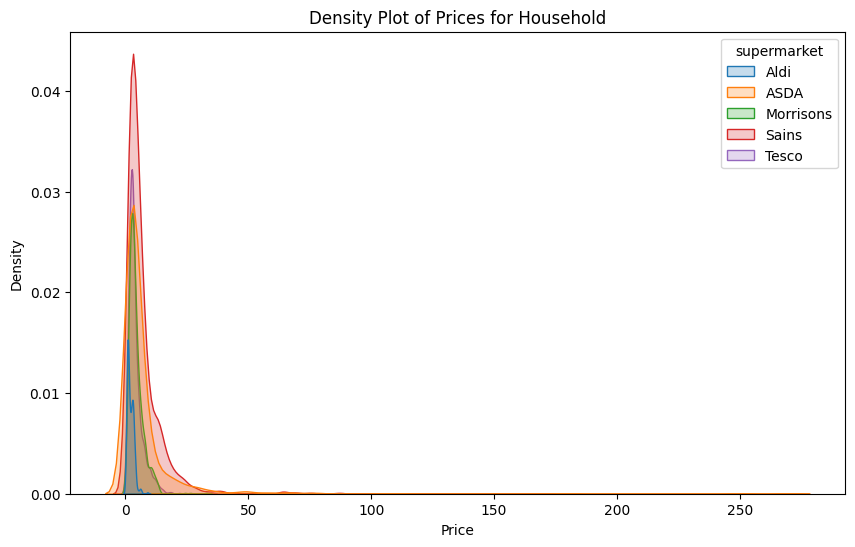

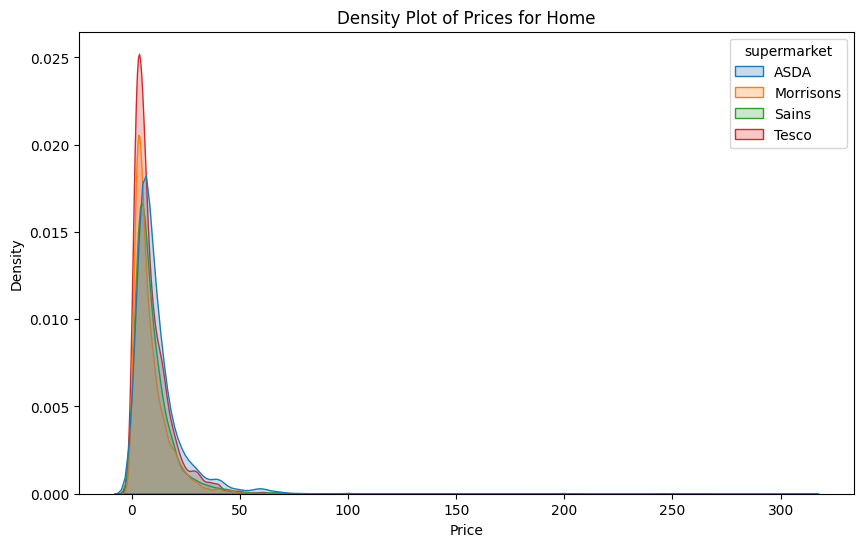

In [288]:
# Create a density plot for each product category
categories = df['category'].unique()

for category in categories:
    plt.figure(figsize=(10, 6))
    subset = df[df['category'] == category]
    sns.kdeplot(data=subset, x='price', hue='supermarket', fill=True)
    plt.title(f'Density Plot of Prices for {category.capitalize()}')
    plt.xlabel('Price')
    plt.ylabel('Density')
    plt.show()

The density plots across various product categories highlight distinct pricing strategies among supermarkets. Aldi consistently shows a peak at lower price ranges, aligning with its discount supermarket model. ASDA also focuses on budget-friendly pricing in several categories. Traditional supermarkets like Morrisons, Sainsbury's and Tesco exhibit more varied price distributions, suggesting a strategy that caters to a broader range of customer preferences. These insights emphasise the competitive nature of the supermarket industry, with different approaches to pricing based on market positioning and target customer segments. By understanding these pricing strategies, supermarkets can better align their offerings with consumer preferences, potentially increasing market share and customer satisfaction.

Now let's examine the distribution of values within the 'categories' column. This will provide insight into the range of products each supermarket sells. We will start with the overall distribution and then look at the distribution for each supermarket individually.

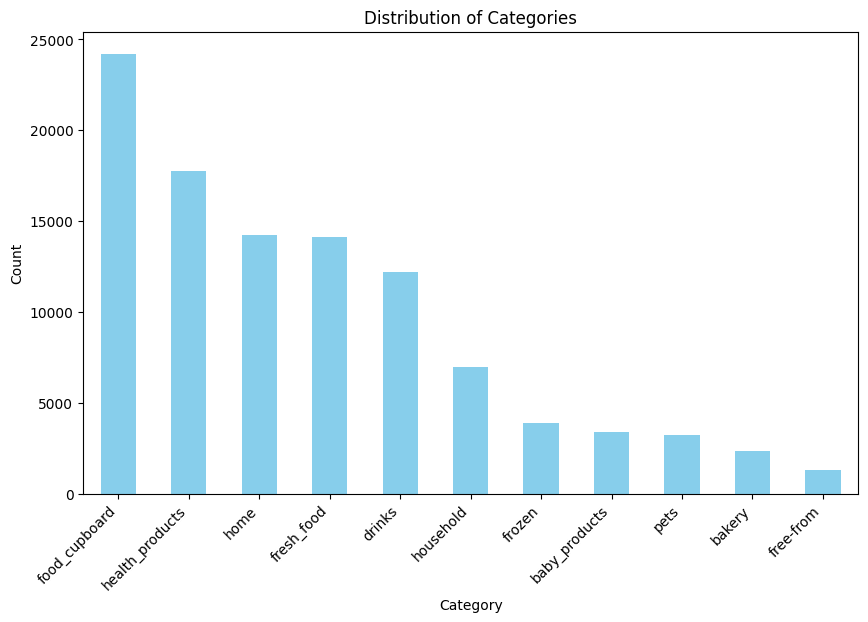

In [289]:
category_counts = df['category'].value_counts()

plt.figure(figsize=(10, 6))
category_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Categories')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

The overall distribution of categories reveals that "food cupboard" items dominate the product range, with nearly 25,000 products, making it the most abundant category. This is followed by "baby products," "home," and "fresh food," which have substantial counts ranging from 15,000 to 20,000 products each. On the other hand, categories such as "bakery" and "free-from" have significantly fewer products, with counts below 5,000. This suggests that staple products, particularly non-perishable items, are in high demand and are a key focus for supermarkets. The considerable variety in "baby products", "home" and "fresh food" indicates that supermarkets aim to meet diverse consumer needs, whereas the lower counts in "bakery" and "free-from" categories may reflect their niche market status or fewer product variations available.

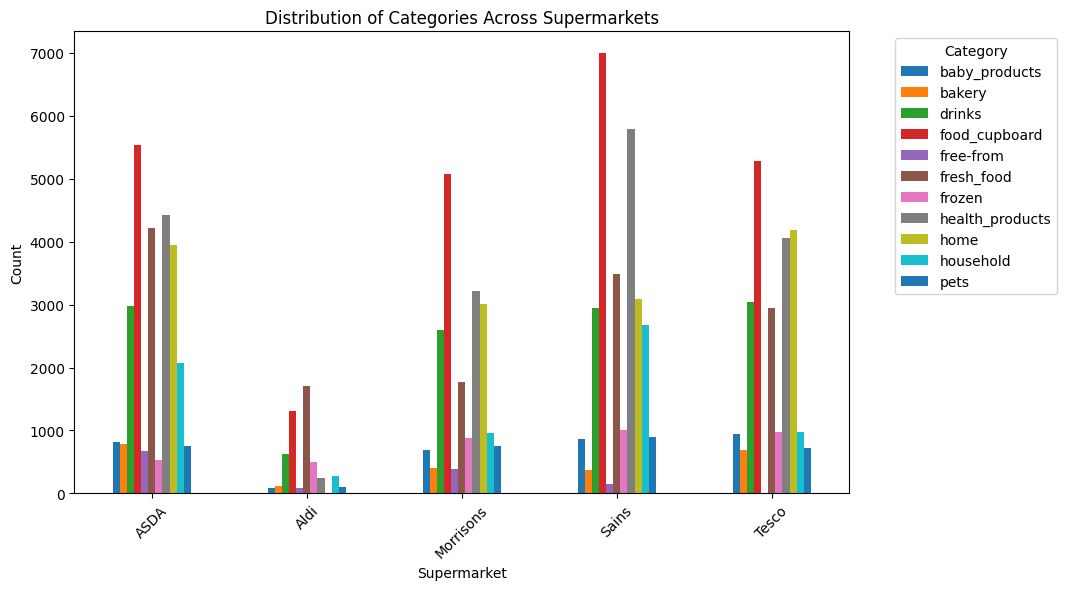

In [290]:
category_counts = df.groupby(['supermarket', 'category']).size().unstack().fillna(0).astype(int)
category_counts.plot(kind='bar', stacked=False, figsize=(10, 6))
plt.title('Distribution of Categories Across Supermarkets')
plt.xlabel('Supermarket')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Examining the category distribution across individual supermarkets, a consistent trend emerges, with "food cupboard" consistently having the highest count across ASDA, Morrisons, Sainsbury's, and Tesco. This highlights the universal importance of staple food items in attracting and retaining customers. Aldi, however, stands out with significantly lower counts across all categories compared to its competitors. This aligns with Aldi's business model as a discount supermarket, focusing on a limited range of high-demand products. Sainsbury's, on the other hand, appears to have the highest product counts in most categories, particularly in "food cupboard" and "fresh food," reflecting its strategy to offer a wide variety of products and cater to a broad customer base.

Each supermarket's category distribution provides further insights into their product strategies. ASDA's high counts in "food cupboard" and "fresh food" suggest a strong focus on essential and perishable goods, essential for everyday shopping. Aldi's lower product counts across all categories highlight its approach to maintaining a focused inventory, offering core products that meet high consumer demand efficiently. Morrisons displays a balanced product range with significant counts in "food cupboard", "fresh food", and "drinks", indicating a strategy to cater to various consumer preferences. Sainsbury's, with the highest counts across multiple categories, emphasises a broad product assortment to attract a wide customer base, aiming to be a one-stop shop for shoppers. Similarly, Tesco's high counts in various categories suggest a comprehensive product range designed to meet diverse consumer needs.

The category distributions across different supermarkets illustrate distinct product strategies. High counts in staple categories like "food cupboard" underscore their critical role in daily consumer needs. Aldi's focused product range contrasts with the broader assortments found in traditional supermarkets like Sainsbury's and Tesco, which aim to cater to a wide array of customer preferences. These visualisations offer valuable insights into each supermarket's market positioning and product strategy, highlighting their approaches to meeting consumer demands and maintaining competitive advantages.

Now let's take a look at the range of own brand products each supermarket provides.

In [291]:
# Separate Boolean values within 'own_brand' column for visualisation
own_brand_by_supermarket = df.groupby(['supermarket', 'own_brand']).size().unstack(fill_value=0)
own_brand_by_supermarket

own_brand,False,True
supermarket,,
ASDA,18864,7894
Aldi,4227,831
Morrisons,14927,4798
Sains,21862,6401
Tesco,17540,6280


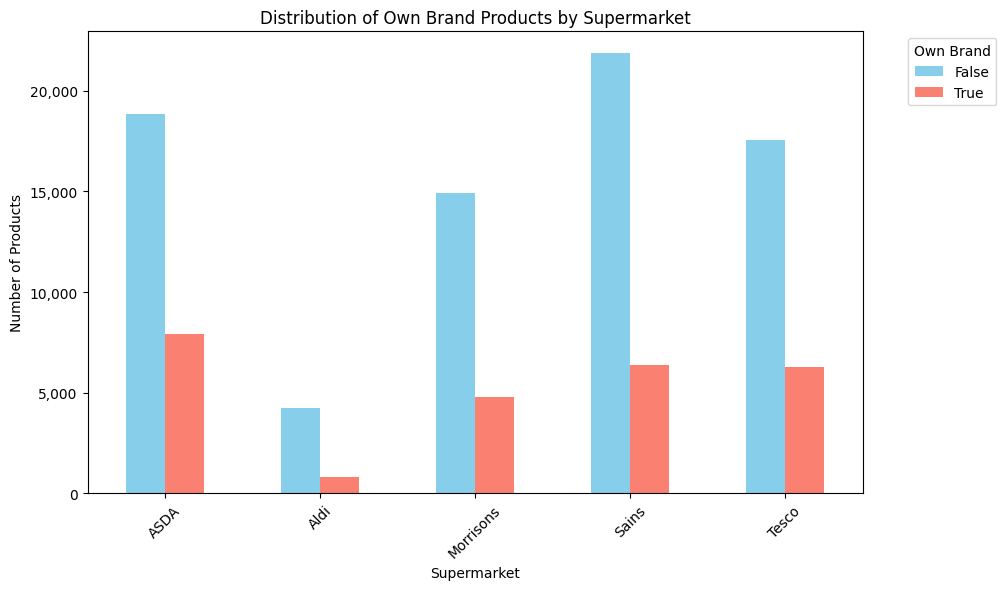

In [292]:
# Plot the grouped bar chart
ax = own_brand_by_supermarket.plot(kind='bar', stacked=False, figsize=(10, 6), color=['skyblue', 'salmon'])
plt.title('Distribution of Own Brand Products by Supermarket')
plt.xlabel('Supermarket')
plt.ylabel('Number of Products')
plt.xticks(rotation=45)
plt.legend(title='Own Brand', labels=['False', 'True'], bbox_to_anchor=(1.05, 1), loc='upper left')
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
plt.savefig('grouped_bar_own_brands.png')
plt.show()

The bar chart illustrates the distribution of own-brand products across various supermarkets, revealing that despite differences in the total product range, all supermarkets employ similar proportions of own-brand products. ASDA leads in the total number of own-brand products, followed by Sainsbury's and Tesco, indicating a strong emphasis on offering own-brand options. Aldi, consistent with its discount model, offers predominantly own-brand products but within a more limited overall product range. Morrisons shows a balanced approach with a significant presence of both own-brand and non-own brand products. To better compare the proportions of own-brand to non-own brand products across supermarkets, normalising the data is necessary. Additionally, analysing own-brand products in relation to pricing and product category could provide further insights into each supermarket's own-brand strategy.

Let's look at this now.

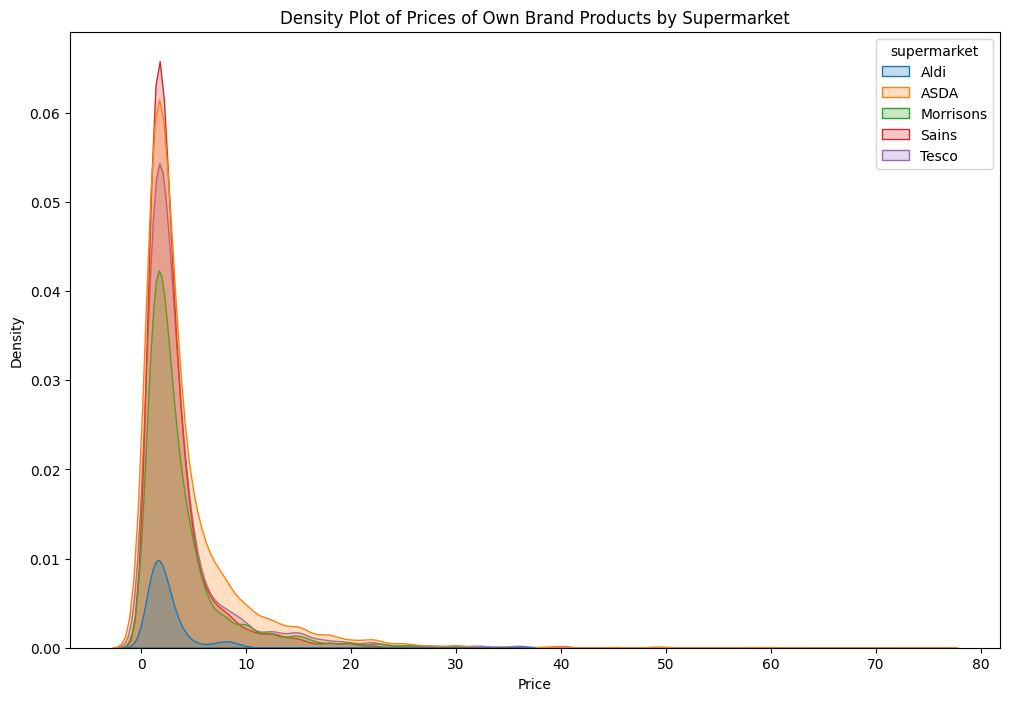

In [293]:
own_brand_df = df[df['own_brand'] == True]

plt.figure(figsize=(12, 8))
sns.kdeplot(data=own_brand_df, x='price', hue='supermarket', fill=True)
plt.title('Density Plot of Prices of Own Brand Products by Supermarket')
plt.xlabel('Price')
plt.ylabel('Density')
plt.savefig('density_plot_own_brand_prices.png')
plt.show()

Sainsbury's has the highest density in this visualisation, so I will create a pivot table to examine the total number of own brand products.

In [294]:
# Create a pivot table to count the number of own-brand products for each supermarket
own_brand_pivot_table = own_brand_df.pivot_table(
    index='supermarket', 
    values='own_brand',  # Use 'own_brand' as the value to count
    aggfunc='count'
)

own_brand_pivot_table

,own_brand
supermarket,
ASDA,7894
Aldi,831
Morrisons,4798
Sains,6401
Tesco,6280


Although ASDA has the highest total own-brand products, the distribution is more spread out, as indicated by the less steep fall in density. The prices of Sainsbury's own brand products are more concentrated.

The density plot of own-brand product prices shows that all supermarkets have a similar overall distribution. Aldi’s prices are concentrated at the lower end, aligning with its discount retailer model, but the distribution is proportionately similar to others — however, this will have to looked at more closely in the next section. ASDA, despite having the most own-brand products, has a broader price spread. Sainsbury’s, Tesco, and Morrisons exhibit similar distributions, offering a mix of affordable and higher-priced items.

Now let's consider the distribution of own brand products per category for each supermarket.

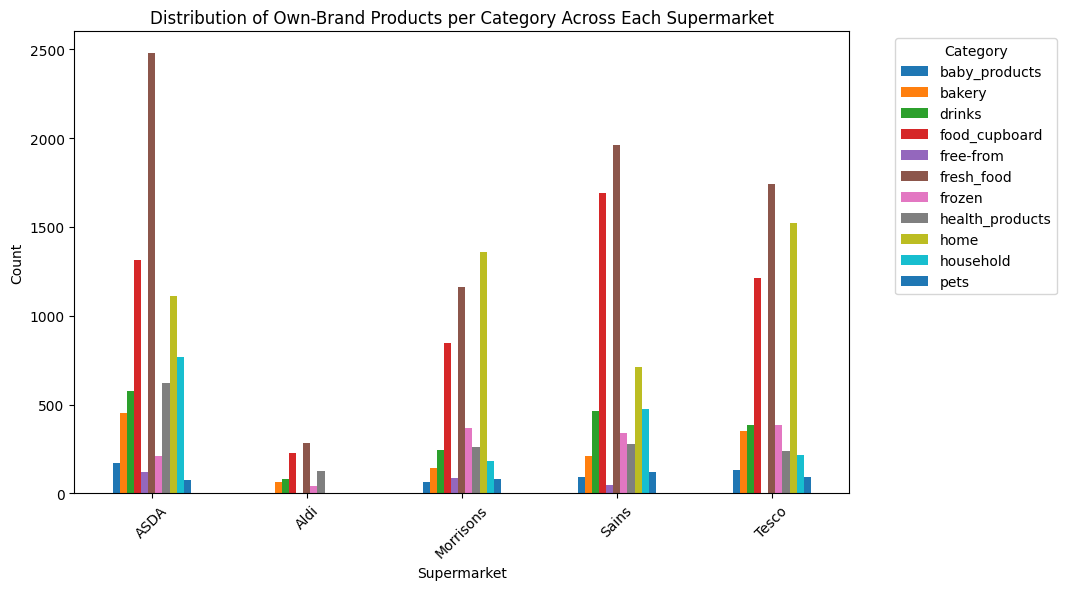

In [295]:
# Filter the dataset to only include own-brand products
own_brand_df = df[df['own_brand'] == True]

category_counts = own_brand_df.groupby(['supermarket', 'category']).size().unstack().fillna(0).astype(int)
category_counts.plot(kind='bar', stacked=False, figsize=(10, 6))
plt.title('Distribution of Own-Brand Products per Category Across Each Supermarket')
plt.xlabel('Supermarket')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig('group_bar_own_brand_category.png')
plt.show()

The bar chart illustrates the distribution of own-brand products across various categories for each supermarket. There is a consistent trend across supermarkets regarding the categories with the most own-brand products. Fresh food emerges as the most frequent category for own-brand products in all supermarkets, except for Morrisons, which has a higher count in home products.

ASDA stands out with a significantly larger number of own-brand fresh food products, almost double the amount of its second largest category, food cupboard items. This highlights ASDA's strong emphasis on fresh food offerings. However, across all supermarkets, the largest categories for own-brand items are consistently fresh food, home, and food cupboard products.

Aldi, on the other hand, has a more limited range of own-brand products, present in only 6 out of the 11 categories: bakery, drinks, food cupboard, fresh food, frozen, and health products. This aligns with Aldi's strategy of offering a focused selection of essential items.

## 4.3: Normalising data 

For this section, my analysis is somewhat limited because I lack sufficient data points for the 'customer_satisfaction' column, which serves as the primary metric of value in my dataset. The original dataset did not include a metric of value, such as customer ratings on products, so I had to incorporate overall supermarket customer satisfaction scores. This effectively means all products within a given supermarket have the same score. Given that these customer satisfaction scores represent overall satisfaction at the supermarket level and are not tied to individual products, normalising these scores within the dataset of individual products would not be meaningful. These scores are already aggregate metrics and normalising them would not provide additional insights. Instead, they should be used as-is to correlate overall supermarket performance with other aggregated metrics like average prices.

Certain columns in the dataset, which represent causes of customer satisfaction, are likely influenced by other causal factors. For example, the distribution of prices in a supermarket may be affected by the supermarket's product range. This concept was highlighted in my research in Chapter 1, where I examined the different supermarket models used by the traditional Big Four and the newer discount supermarkets. Discount supermarkets, with their smaller product ranges, can focus on offering lower everyday prices. In contrast, traditional supermarkets, with their larger product ranges, often include more expensive items.

If the dataset contained a more detailed metric for customer satisfaction, such as customer reviews of products, I could normalise these values to better understand their relationships with other factors. For example, I could normalise customer reviews by dividing them by columns such as 'price', 'total_products', or 'total_own_brand_products', depending on which factor appears to have the most significant effect on customer satisfaction. Once normalised, I could then plot the normalised satisfaction scores against these factors to identify any significant relationships or patterns.

Since this dataset was originally scraped from supermarket websites, it might be possible to retrieve product ratings by scraping these websites, provided the ratings are available. However, given the scope of this project, it is not feasible to pursue this approach at the moment.

Thus, by normalising these causal factors, I aim to uncover underlying patterns and relationships that might not be immediately evident. This approach allows me to make the most of the available data, even in the absence of a more comprehensive customer satisfaction metric.

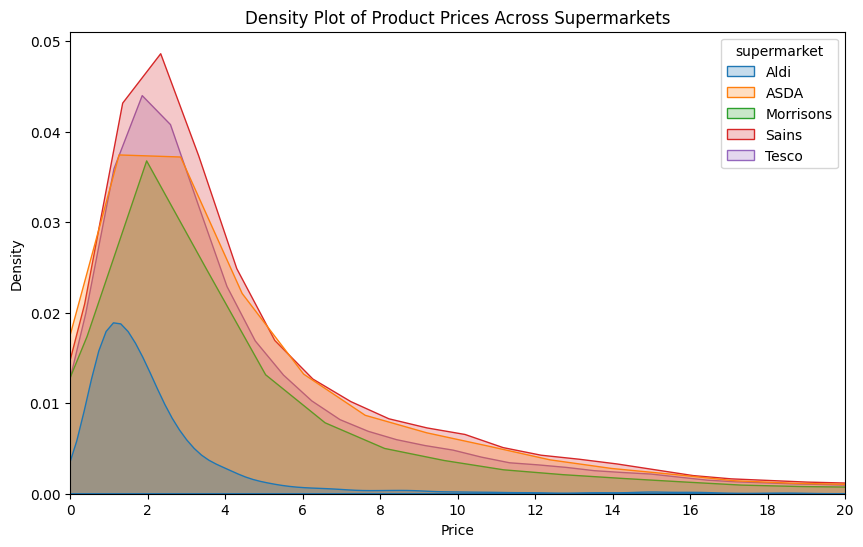

In [296]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df, x='price', hue='supermarket', fill=True)
plt.xlim(0, 20)
plt.xticks(ticks=range(0, 21, 2))
plt.title('Density Plot of Product Prices Across Supermarkets')
plt.xlabel('Price')
plt.ylabel('Density')
plt.savefig('density_plot_prices.png')
plt.show()

Here is the density plot of product prices across supermarkets, with the x-axis limited to £50 for readadbility. There appears to be a relationship between the number of products a supermarket has - represented here by the density of values within the price column - and the prices of those products. Aldi, which has a lower range of products, has significantly lower prices.


To normalise product prices, we must refer back to the aggregate statistics in the pivot table created in section 4.1.

In [297]:
pivot_table

,supermarket,supermarket_total_products,supermarket_total_own_brand_products,average_price,average_own_brand_price
0,Aldi,5058,831,2.27,2.60
1,ASDA,26758,7894,5.75,4.38
2,Morrisons,19725,4798,5.09,3.88
3,Sains,28263,6401,5.54,3.34
4,Tesco,23820,6280,5.24,3.94


It might be useful here to visualise each supermarket's product range in a bar chart.

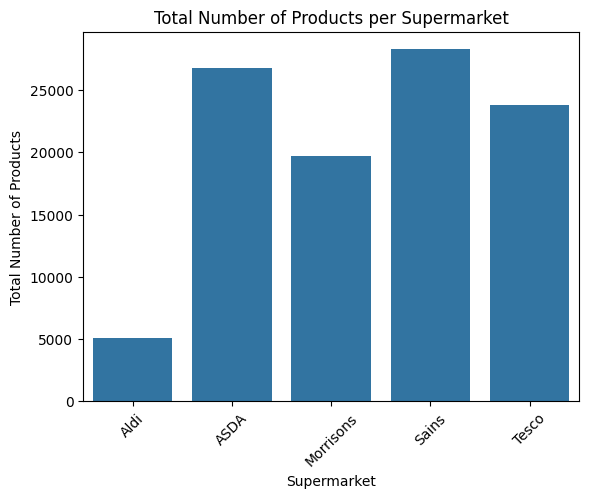

In [300]:
sns.barplot(data=pivot_table, x='supermarket', y='supermarket_total_products')
plt.xlabel('Supermarket')
plt.ylabel('Total Number of Products')
plt.title('Total Number of Products per Supermarket')
plt.xticks(rotation=45)
plt.show()

The difference in product ranges between Aldi and the traditional supermarkets really hits home when visualised in this way. Normalising prices helps reveal whether Aldi generally prices its products lower compared to others, regardless of the total number of products offered.

To do this, we must calculate the total price of all products for each supermarket and divide it by the total number of products. This is a form of normalisation that essentially calculates the average price per product. Therefore, we can visualise the normalised price by creating a bar chart from the average prices for each supermarket contained in the pivot table.

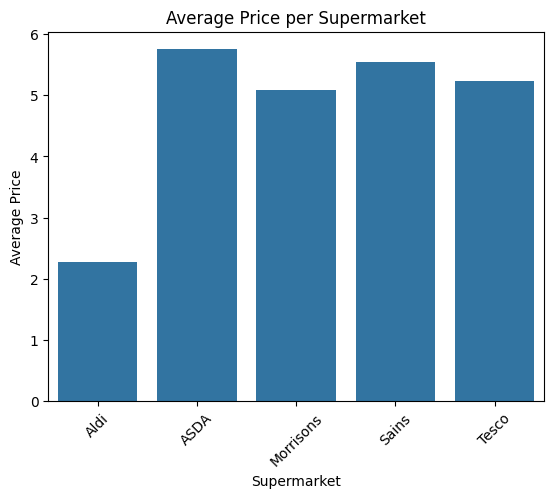

In [301]:
sns.barplot(data=pivot_table, x='supermarket', y='average_price')
plt.xlabel('Supermarket')
plt.ylabel('Average Price')
plt.title('Average Price per Supermarket')
plt.xticks(rotation=45)
plt.show()

Aldi has the lowest normalised price, indicating that on average, its products are priced lower compared to other supermarkets. ASDA has the highest normalised price, suggesting that it generally prices its products higher on average compared to the others. Morrisons, Sainsbury's, and Tesco have relatively similar normalised prices, all higher than Aldi but lower than ASDA, indicating a more moderate pricing strategy.

The bar chart and density plot align well, confirming that supermarkets with higher normalised prices also show higher concentrations of higher-priced products in the density plot. ASDA's higher normalised price is reflected in its density plot, which shows a higher concentration of higher-priced products. Morrisons, Sainsbury's, and Tesco have similar pricing strategies, indicated by both the similar heights in the bar chart and the overlapping density plots. Additionally, both plots show that Aldi has lower prices overall, with a more spread out price distribution.

The normalised price bar chart serves as a summary statistic, providing a quick overview of the average pricing strategy of each supermarket. The density plot adds depth to this summary by showing the distribution and range of individual product prices, offering more detailed insights into pricing patterns.

Now let's look at the prices of own brand products per supermarket.

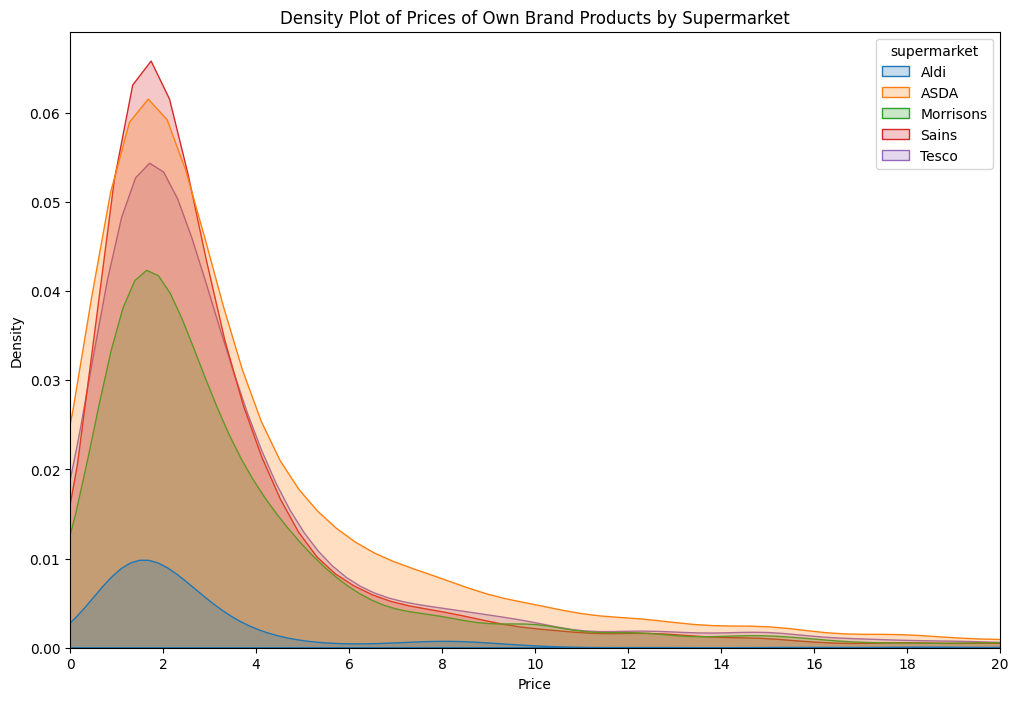

In [302]:
own_brand_df = df[df['own_brand'] == True]

plt.figure(figsize=(12, 8))
sns.kdeplot(data=own_brand_df, x='price', hue='supermarket', fill=True)
plt.xlim(0, 20)
plt.xticks(ticks=range(0, 21, 2))
plt.title('Density Plot of Prices of Own Brand Products by Supermarket')
plt.xlabel('Price')
plt.ylabel('Density')
plt.savefig('density_plot_own_brand_prices.png')
plt.show()

Again, there appears to be a relationship between the number of own brand products a supermarket sells and the prices of those own brand products. Aldi's peak is considerably smaller than the others, showing a smaller distribution of prices for own brand products.

To normalise the prices of own brand products, we divide it by the total number of own brand products in each supermarket - again effectively a calculating an average price of own brand products, which we previously prepared in the pivot table.

In [303]:
pivot_table

,supermarket,supermarket_total_products,supermarket_total_own_brand_products,average_price,average_own_brand_price
0,Aldi,5058,831,2.27,2.60
1,ASDA,26758,7894,5.75,4.38
2,Morrisons,19725,4798,5.09,3.88
3,Sains,28263,6401,5.54,3.34
4,Tesco,23820,6280,5.24,3.94


Let's visualise the total number of own brand products per supermarket in a bar chart.

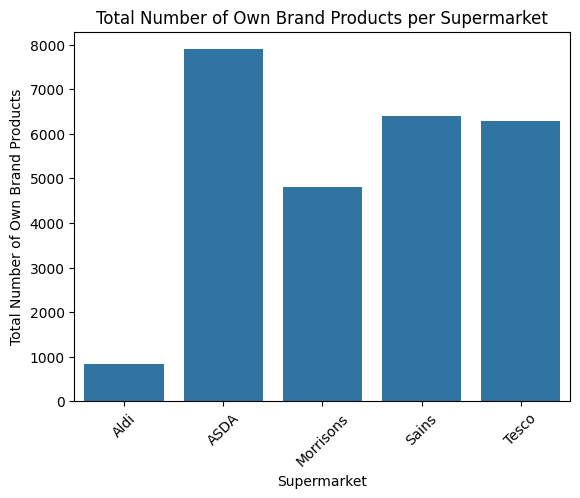

In [306]:
sns.barplot(data=pivot_table, x='supermarket', y='supermarket_total_own_brand_products')
plt.xlabel('Supermarket')
plt.ylabel('Total Number of Own Brand Products')
plt.title('Total Number of Own Brand Products per Supermarket')
plt.xticks(rotation=45)
plt.show()

This is similar to the bar chart for total number of products, with Aldi have significantly less own brand products. This is unsurprising, given its relatively low product range. However, ASDA is shown to have quite a bit more own brand products than the other 3 traditional supermarkets. While Sainsbury's has a higher total number of products, ASDA has a higher number of own brand products. 

Normalising own brand prices helps reveal whether Aldi generally prices its own brand products lower compared to others and whether ASDA generally prices its own brand products higher compared to others, regardless of the total number of products offered.

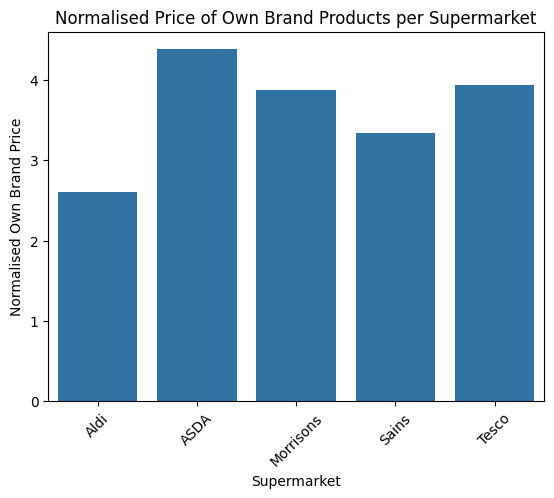

In [307]:
sns.barplot(data=pivot_table, x='supermarket', y='average_own_brand_price')
plt.xlabel('Supermarket')
plt.ylabel('Normalised Own Brand Price')
plt.title('Normalised Price of Own Brand Products per Supermarket')
plt.xticks(rotation=45)
plt.show()

The normalised prices shown in the bar charts represent the average price of own brand products for each supermarket. This average takes into account all the prices in the dataset, including higher-priced outliers. In contrast, the density plot shows the distribution of individual product prices, highlighting the most common price ranges (peaks). The observed difference between the normalised (average) prices and the peak values in the density plot is due to the influence of these higher-priced outliers, which elevate the mean price.

For instance, Aldi's density plot displays a peak at a lower price range, indicating that most of its own brand products are very cheap. However, the average price is slightly higher than this peak because it includes some higher-priced products in its calculation. Similarly, ASDA has a broad distribution with a peak at a higher price range, but its average price is even higher due to the presence of more expensive products. Morrisons, Sainsbury’s, and Tesco exhibit overlapping distributions with similar price ranges in the density plot, yet their average prices are somewhat higher, reflecting the inclusion of higher-priced items.

This difference underscores the importance of examining both the average prices and the distribution of prices to fully understand pricing strategies. The density plot provides insight into the most frequent price points, while the average price gives a broader perspective by accounting for all price points, including outliers. Together, these metrics reveal the comprehensive pricing strategies employed by each supermarket, helping to identify whether they lean towards budget or premium pricing.

To end, I will add the normalised prices to the main dataset, in order to explore how customer satisfaction scores correlate with it in the next chapter. I decided not to add the normalised own brand prices, as not every row in the dataset is an own brand product.

In [308]:
pivot_table = pivot_table.rename(columns={'average_price': 'price_per_product', 'average_own_brand_price': 'price_per_own_brand_product'})
pivot_table

,supermarket,supermarket_total_products,supermarket_total_own_brand_products,price_per_product,price_per_own_brand_product
0,Aldi,5058,831,2.27,2.60
1,ASDA,26758,7894,5.75,4.38
2,Morrisons,19725,4798,5.09,3.88
3,Sains,28263,6401,5.54,3.34
4,Tesco,23820,6280,5.24,3.94


In [309]:
if 'price_per_product' not in df.columns:
    df = df.merge(pivot_table[['supermarket', 'price_per_product']], on='supermarket', how='left')

df.head()

,supermarket,price,price_per_unit,unit,product_name,category,own_brand,customer_satisfaction,supermarket_total_products,supermarket_total_own_brand_products,price_per_product
0,Aldi,1.69,0.37,kg,Plant Menu Vegetable Burgers 454g/4 Pack,free-from,False,73,5058,0,2.27
1,Aldi,1.69,0.37,kg,Plant Menu Spicy Bean Burgers 454g/4 Pack,free-from,False,73,5058,0,2.27
2,Aldi,1.69,3.70,kg,Plant Menu No Chicken Burgers 227g/2 Pack,free-from,False,73,5058,0,2.27
3,Aldi,1.69,7.40,kg,Veggie Menu Bean & Vegetable Burgers 227g/2 Pack,free-from,False,73,5058,0,2.27
4,Aldi,1.49,3.70,kg,Plant Menu No Chicken Pies 2x200g,free-from,False,73,5058,0,2.27


In [310]:
if 'price_per_own_brand_product' not in df.columns:
    df = df.merge(pivot_table[['supermarket', 'price_per_own_brand_product']], on='supermarket', how='left')
    df['price_per_own_brand_product'] = df.apply(
        lambda row: row['price_per_own_brand_product'] if row['own_brand'] else 0, axis=1
    )
df['price_per_own_brand_product'].unique()

array([0.  , 2.6 , 4.38, 3.88, 3.34, 3.94])

In [311]:
df.head()

,supermarket,price,price_per_unit,unit,product_name,category,own_brand,customer_satisfaction,supermarket_total_products,supermarket_total_own_brand_products,price_per_product,price_per_own_brand_product
0,Aldi,1.69,0.37,kg,Plant Menu Vegetable Burgers 454g/4 Pack,free-from,False,73,5058,0,2.27,0.0
1,Aldi,1.69,0.37,kg,Plant Menu Spicy Bean Burgers 454g/4 Pack,free-from,False,73,5058,0,2.27,0.0
2,Aldi,1.69,3.70,kg,Plant Menu No Chicken Burgers 227g/2 Pack,free-from,False,73,5058,0,2.27,0.0
3,Aldi,1.69,7.40,kg,Veggie Menu Bean & Vegetable Burgers 227g/2 Pack,free-from,False,73,5058,0,2.27,0.0
4,Aldi,1.49,3.70,kg,Plant Menu No Chicken Pies 2x200g,free-from,False,73,5058,0,2.27,0.0


## 4.4: Subgroups & Outliers

Given that I had to manually add a metric of value to the dataset, with a limited range of data points, I will begin this section by briefly examining the density plot for customer satisfaction, followed by density plots and bar charts for the columns representing potential causes of customer satisfaction. By doing this, we might uncover differences that help explain the distribution of customer satisfaction scores.

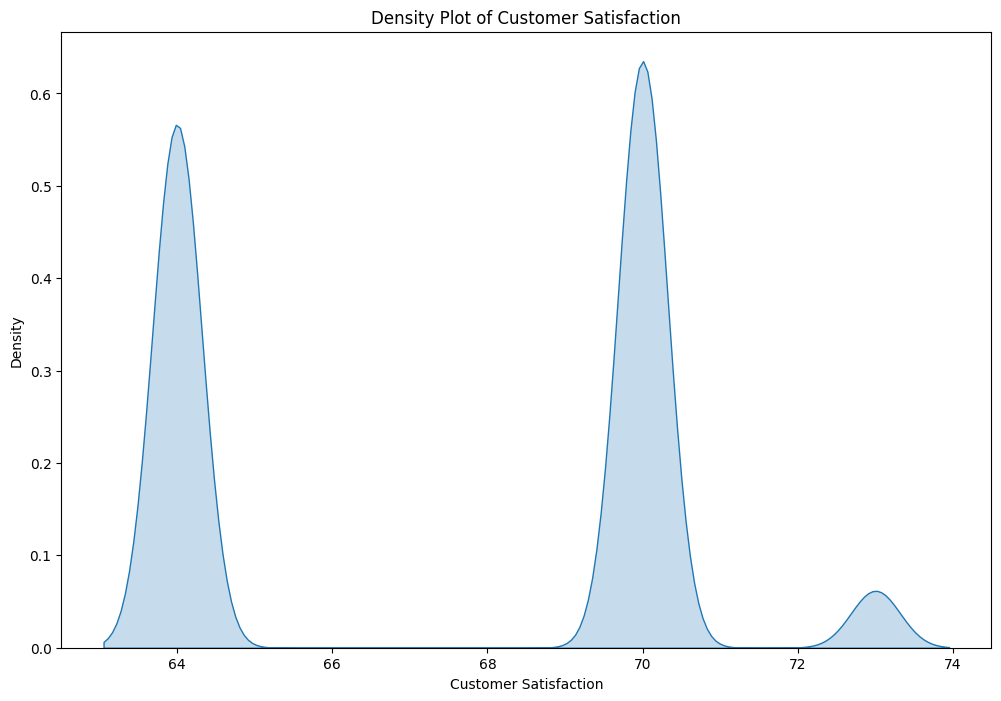

In [313]:
# Create a density plot for the 'price' column
plt.figure(figsize=(12, 8))
sns.kdeplot(data=df, x='customer_satisfaction', fill=True)
plt.title('Density Plot of Customer Satisfaction')
plt.xlabel('Customer Satisfaction')
plt.ylabel('Density')
plt.show()

The lack of unique data points for this chart makes it perhaps less useful to examine in detail for this section. There are three peaks here, representing the three unique customer satisfaction scores for each supermarket. Aldi is the high outlier, with the highest customer satisfaction score at 73. Morrisons and ASDA are the low outliers, both obtaining a score of 64.

On the other hand, the two inliers are Sainsbury’s and Tesco, each with a customer satisfaction score of 70. The density of each plot represents the number of products each supermarket sells, with the first two peaks representing a combination of two supermarkets: the first being ASDA and Morrisons, and the second Sainsbury’s and Tesco. There is a slight discernible trend: Aldi, which has a significantly lower product range, has the highest customer satisfaction score, while ASDA and Morrisons, which have a significantly higher product range, have the lowest customer satisfaction scores. However, Sainsbury’s and Tesco have a higher peak, indicating they have a higher combined product range, with a customer satisfaction score only three points lower than Aldi and six points higher than ASDA and Morrisons. This suggests customer satisfaction cannot solely be attributed to a lower product range.

Thus, although Aldi is the clear outlier here and worth examining more closely, especially when exploring the distributions in the other charts, Sainsbury’s and Tesco represent outliers in the sense that they do not follow the same trend as the others – i.e., higher customer satisfaction correlating with a lower product range, and lower customer satisfaction correlating with a higher product range.

Next, let's examine the various density plots created to show the distribution of prices.

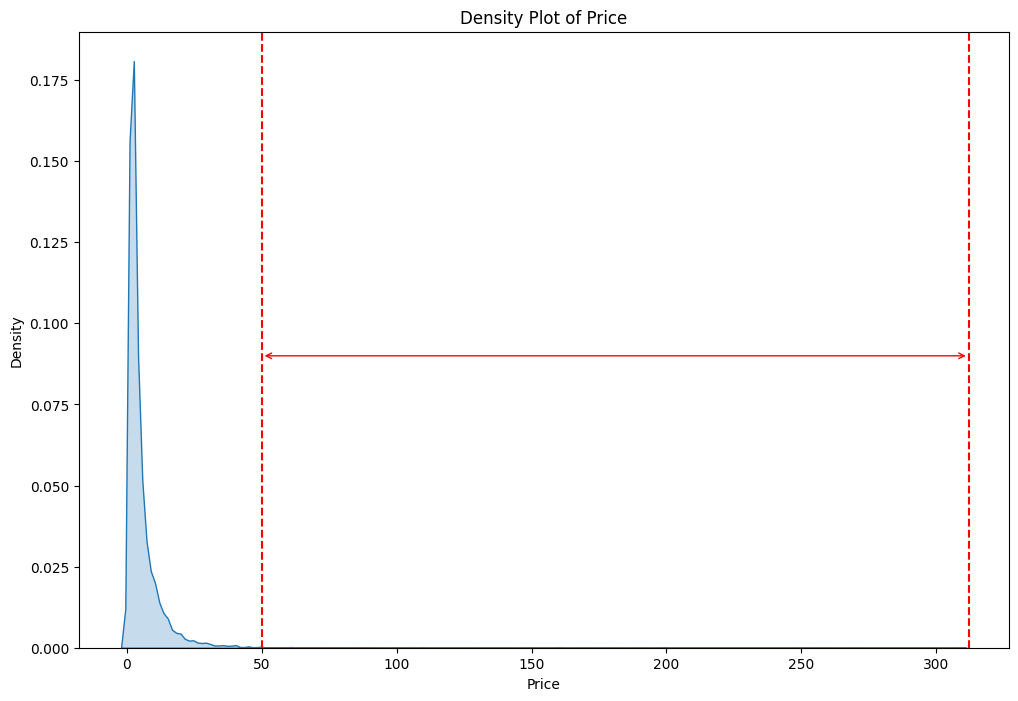

In [314]:
# Create a density plot for the 'price' column
plt.figure(figsize=(12, 8))
ax = sns.kdeplot(data=df, x='price', fill=True)
plt.title('Density Plot of Price')
plt.xlabel('Price')
plt.ylabel('Density')
ax.axvline(x=50, color='r', linestyle='--')
ax.axvline(x=312, color='r', linestyle='--')
ax.annotate('', xy=(50, 0.09), xytext=(312, 0.09), arrowprops=dict(arrowstyle='<->', color='r'))
plt.show()

Examining the distribution of prices, we can see that all supermarkets focus mainly on selling products at the cheaper end, within a price range of £0 to £50, most of which are under £25. The outliers in this context appear to be products on the more expensive end.

In [315]:
expensive_products = df[df['price'] > 50]

expensive_products.shape

(317, 12)

In [316]:
df.shape

(103624, 12)

Here we can see there are only 317 out 103,624 products sold across all supermarkets that are more expensive than £50. Let's look at the distribution of these prices for each supermarket.

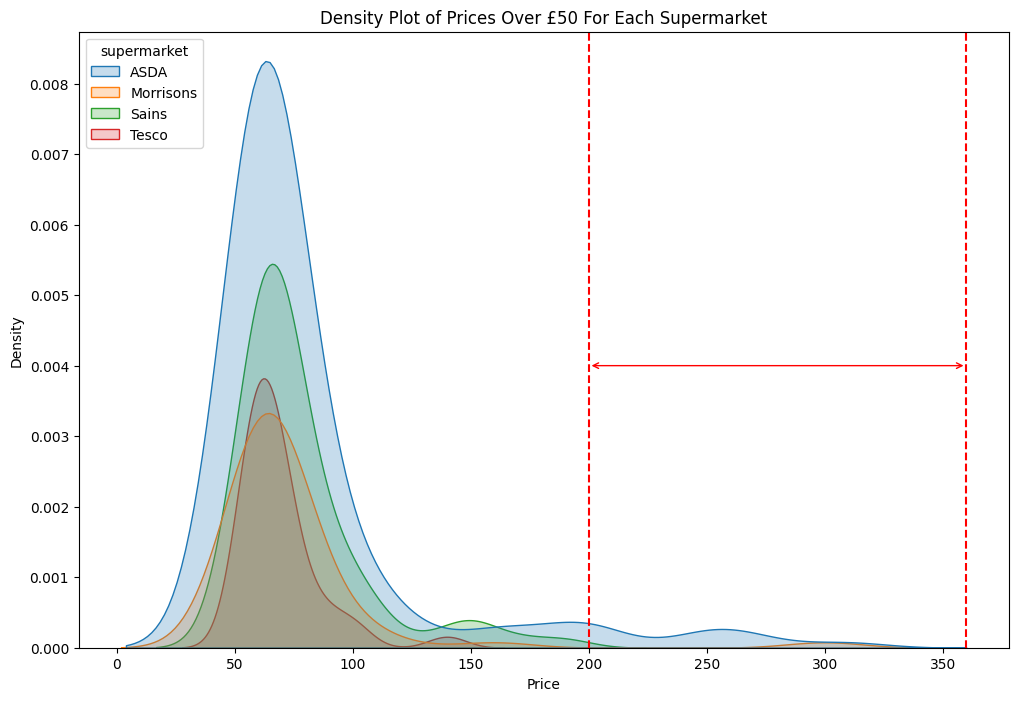

In [317]:
# Create a density plot for the 'price' column
plt.figure(figsize=(12, 8))
ax = sns.kdeplot(data=expensive_products, x='price', hue='supermarket', fill=True)
plt.title('Density Plot of Prices Over £50 For Each Supermarket')
plt.xlabel('Price')
plt.ylabel('Density')
ax.axvline(x=200, color='r', linestyle='--')
ax.axvline(x=360, color='r', linestyle='--')
ax.annotate('', xy=(200, 0.004), xytext=(360, 0.004), arrowprops=dict(arrowstyle='<->', color='r'))
plt.show()

From this plot, we can immediately see that Aldi is absent, meaning there is no product over £50 from this supermarket in the dataset. While not an error necessarily, this could perhaps be attributed to the Aldi website not displaying the full range of products in normally would in-store. This is particularly plausible, given the presence of the "Aldi Finds" or "Special Buys" aisles in-store, which feature a rotating selection of special offers and limited time deals on miscellaneous goods.

Moreover, the other outlier in the density plot above is ASDA, which has a much higher, wider peak, indicating that ASDA sell a wider range of more expensive products at higher prices. This can perhaps be attributed to ASDA's focus on its home range, known as ASDA George Home. 

While the four peaks rise to their highest at around the £60 mark, Sainsbury's has the second highest distribution of prices here and the upper boundary stops at £200 benchmark. Morrison's, with the lowest peak, ends at £190, only to rise again with a very small slope between £270 and £350, suggesting they sell a limited range of very expensive items.

In [318]:
most_expensive_products = expensive_products[expensive_products['price'] > 200]
most_expensive_products

,supermarket,price,price_per_unit,unit,product_name,category,own_brand,customer_satisfaction,supermarket_total_products,supermarket_total_own_brand_products,price_per_product,price_per_own_brand_product
7734,ASDA,269.99,269.99,unit,Shark Anti Hair Wrap Pet Upright Vacuum Cleane...,household,False,64,26758,0,5.75,0.0
20347,ASDA,249.99,249.99,unit,Shark Anti Hair Wrap Cordless Vacuum Cleaner,household,False,64,26758,0,5.75,0.0
20901,ASDA,249.99,249.99,unit,Xbox Series S Console,home,False,64,26758,0,5.75,0.0
22163,ASDA,309.00,309.00,unit,Nintendo Switch OLED White,home,False,64,26758,0,5.75,0.0
29111,ASDA,259.00,259.00,unit,Nintendo Switch Console - Neon,home,False,64,26758,0,5.75,0.0
51471,Morrisons,300.00,300.00,unit,Oral-B Io Series 6 Ultimate Clean…,health_products,False,64,19725,0,5.09,0.0


As we can see here, 5 out of the 6 products priced over £200 in the dataset are from ASDA; the other from Morrisons. The categories of the products range from home, household to health. All of the products in the home section are video game consoles.

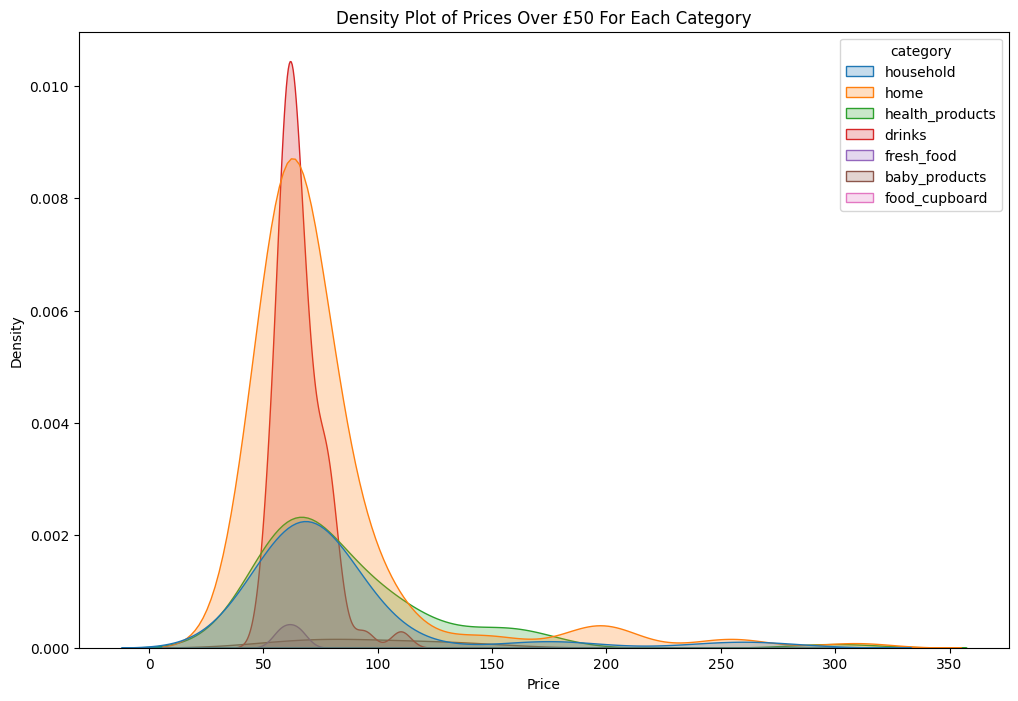

In [319]:
# Create a density plot for the 'price' column
plt.figure(figsize=(12, 8))
sns.kdeplot(data=expensive_products, x='price', hue='category', fill=True, warn_singular=False)
plt.title('Density Plot of Prices Over £50 For Each Category')
plt.xlabel('Price')
plt.ylabel('Density')
plt.show()

Surprisingly, the category with the highest distribution of prices over £50 is drinks, although it is the narrowest, falling at about £120. Unsurprisingly, the categories with the widest distribution of prices over £50 are home, household and health products.

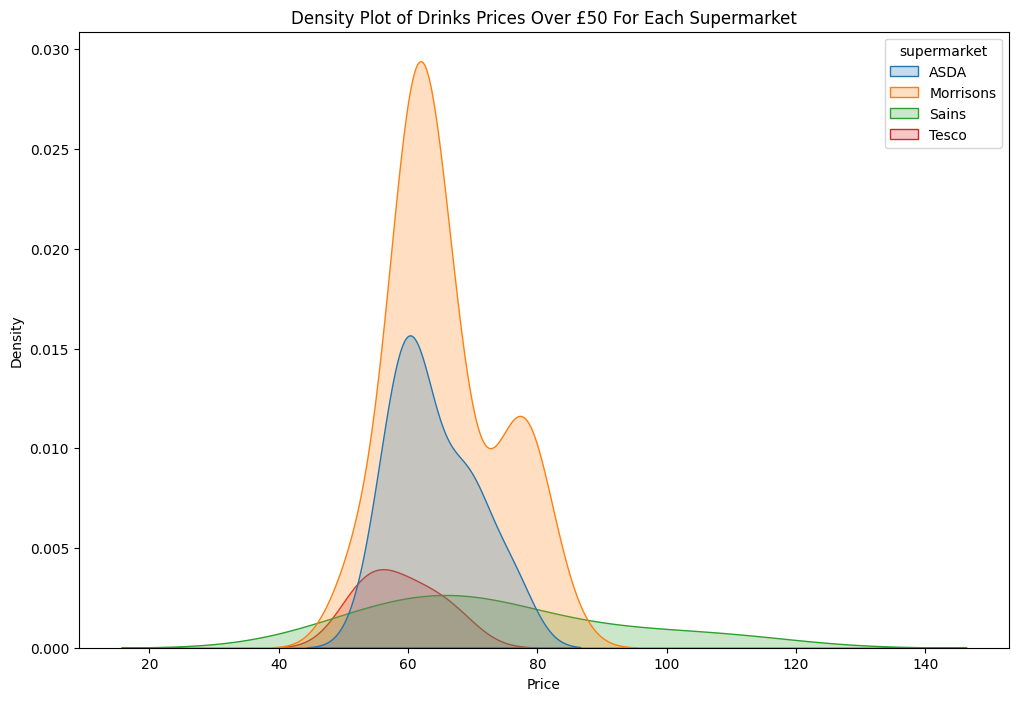

In [320]:
expensive_drinks = expensive_products[expensive_products['category'] == 'drinks']

plt.figure(figsize=(12, 8))
sns.kdeplot(data=expensive_drinks, x='price', hue='supermarket', fill=True, warn_singular=False)
plt.title('Density Plot of Drinks Prices Over £50 For Each Supermarket')
plt.xlabel('Price')
plt.ylabel('Density')
plt.show()

Morrisons have a significantly higher distribution of prices for drinks over £50, almost double the height of the second highest distribution, which is ASDA. However, the widest distribution of prices of drinks over £50 is Sainsburys. There could be a relationship discerned here, where customer's may be more satisfied with a lower range of expensive alcoholic drinks, as Sainsbury's and Tesco, which received higher customer satisfaction scores, have a much lower distribution than Morrisons and ASDA, which received lower customer satisfaction scores. This, however, is quite niche and probably unlikely, given the amount of data we have for customer satisfaction.

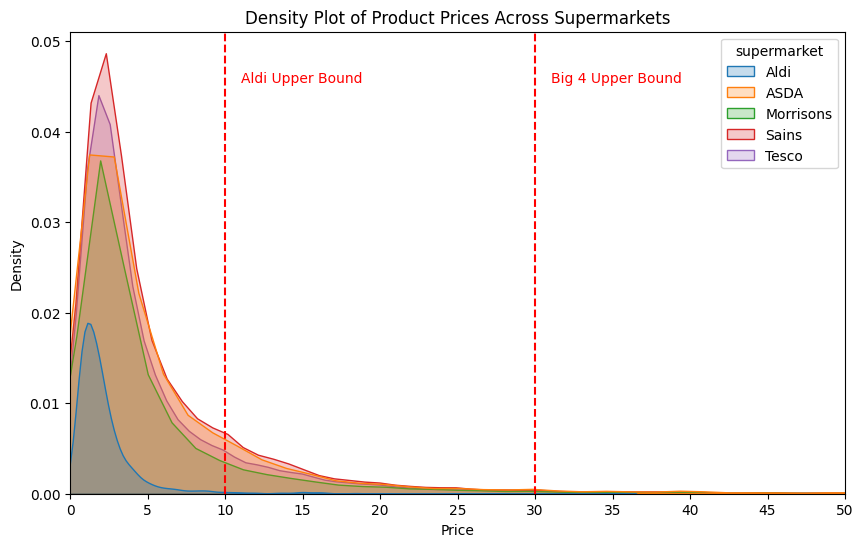

In [321]:
plt.figure(figsize=(10, 6))
ax = sns.kdeplot(data=df, x='price', hue='supermarket', fill=True)
plt.xlim(0, 50)
plt.xticks(ticks=range(0, 51, 5))
plt.title('Density Plot of Product Prices Across Supermarkets')
plt.xlabel('Price')
plt.ylabel('Density')
ax.axvline(x=10, color='r', linestyle='--')
ax.axvline(x=30, color='r', linestyle='--')
ax.text(10 + 1, plt.ylim()[1]*0.9, 'Aldi Upper Bound', color='r', rotation=0, verticalalignment='center')
ax.text(30 + 1, plt.ylim()[1]*0.9, 'Big 4 Upper Bound', color='r', rotation=0, verticalalignment='center')
plt.show()

By visualising the prices across individual supermarkets and focusing in on prices up to £50 (to make it easier to examine), it becomes clear that Aldi is the predominant outlier. Let's limit the x-axis again, this time £20, and have a closer look at the peak values and boundaries.

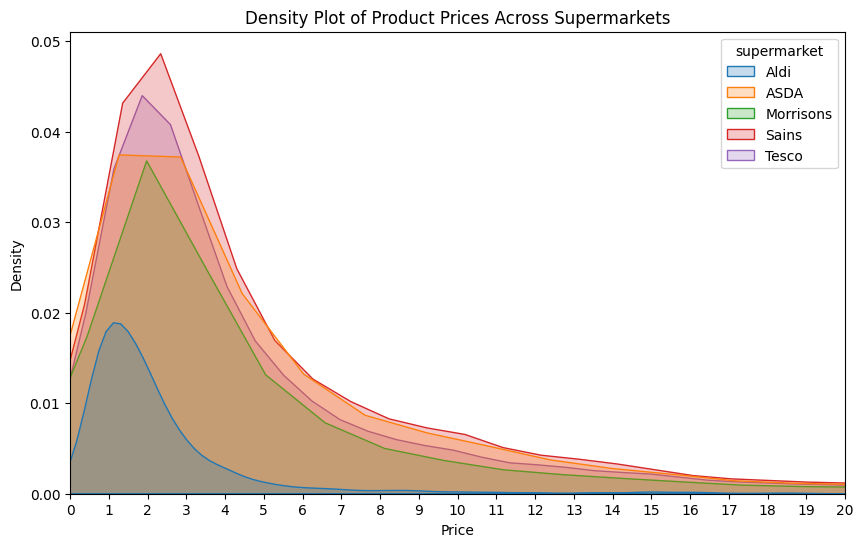

In [322]:
aldi_prices = df[df['supermarket'] == 'Aldi']
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df, x='price', hue='supermarket', fill=True)
plt.xlim(0, 20)
plt.xticks(ticks=range(0, 21, 1))
plt.title('Density Plot of Product Prices Across Supermarkets')
plt.xlabel('Price')
plt.ylabel('Density')
plt.show()

Aldi has a peak value of approximately £1.10, with an upper boundary of £10, although it begins to descend more gently after £5. Whereas ASDA has a similar peak value - of approximately £1.20 - it plateaus until £4 and has a similar upper boundary to the other traditional supermarkets - over £30. Tesco has a peak value of approximately £1.90, while Morrisons and Sainsburys have peak values of £2 and £3 respectively.

Therefore, Aldi has a higher distribution of its products at a significantly lower boundary, which suggests low prices could be a significant cause of customer satisfaction. Aldi also stands out for its lower range of products, which is reflected in the size of its peak. This suggests that a lower range of products might in turn be a cause of lower prices.

In [323]:
aldi_prices = df[(df['supermarket'] == 'Aldi') & (df['price'] > 10)]
aldi_prices.shape

(102, 12)

In [324]:
aldi_products = df[df['supermarket'] == 'Aldi']
aldi_products.shape

(5058, 12)

Out of the 5,058 Aldi products in the dataset, 102 are priced over £10. This is equivalent to 2%. This compares to 11% of Morrisons products, 12% of Tesco products and 13% of both ASDA and Sainsbury's products, as calculated and displayed in the table below.

In [325]:
# Initialise an empty list to store the results
results = []

# List of supermarkets
supermarkets = df['supermarket'].unique()

# Calculate the percentage of products over £10 for each supermarket
for supermarket in supermarkets:
    total_products = df[df['supermarket'] == supermarket].shape[0]
    products_over_10 = df[(df['supermarket'] == supermarket) & (df['price'] > 10)].shape[0]
    percentage_over_10 = int((products_over_10 / total_products) * 100)
    results.append({'supermarket': supermarket, 'percentage_over_10': percentage_over_10})

# Convert the results into a DataFrame
results_df = pd.DataFrame(results)

results_df

,supermarket,percentage_over_10
0,Aldi,2
1,ASDA,13
2,Morrisons,10
3,Sains,13
4,Tesco,12


Now let's try to identify outliers within the bar charts for the distribution of categories in the dataset.

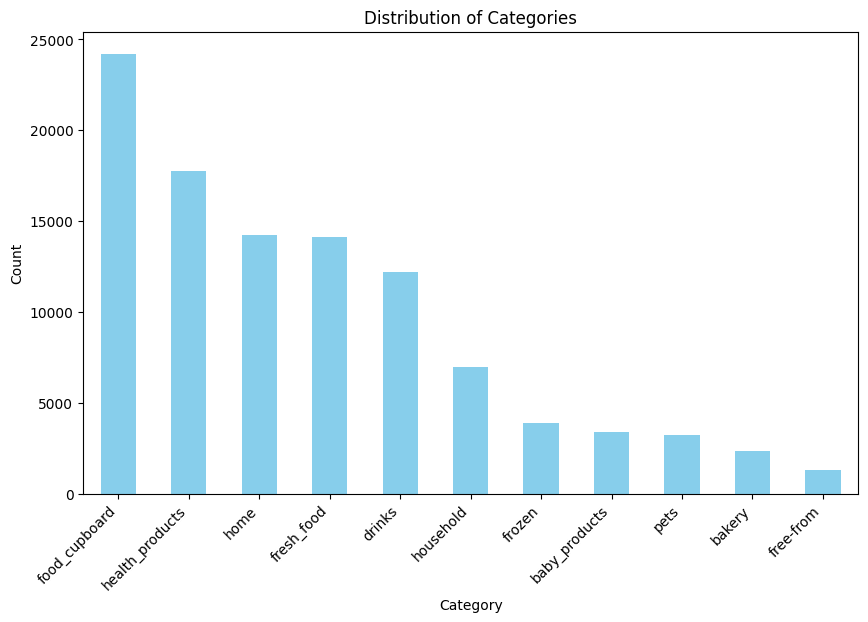

In [326]:
category_counts = df['category'].value_counts()

plt.figure(figsize=(10, 6))
category_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Categories')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

Here we can see that the categories with the most products in the dataset, irrespective of which supermarket they are sold in, are food cupboard, health products, home, fresh food and drinks. 

Now let's look at the grouped bar chart to examine the distribution of categories across each supermarket.

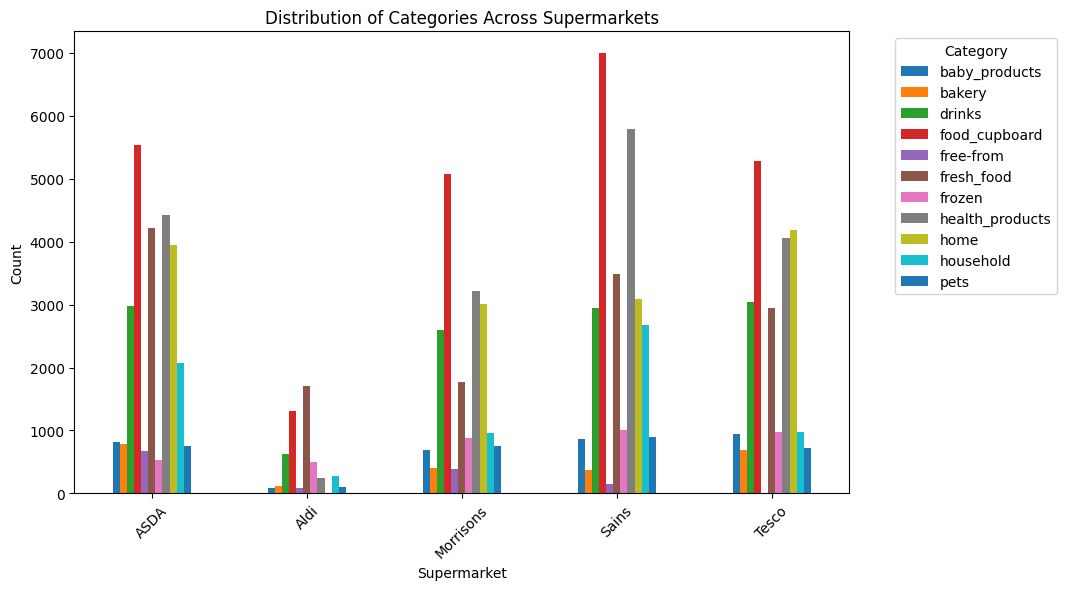

In [327]:
category_counts = df.groupby(['supermarket', 'category']).size().unstack().fillna(0).astype(int)
category_counts.plot(kind='bar', stacked=False, figsize=(10, 6))
plt.title('Distribution of Categories Across Supermarkets')
plt.xlabel('Supermarket')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Aldi stands out as a clear outlier among the supermarkets, not only due to its significantly lower number of products but also because its highest category is fresh food, unlike the other supermarkets where food cupboard items dominate. Interestingly, fresh food is the top category for Aldi, followed by food cupboard, which is its second-highest category.

Moreover, Aldi has noticeably lower rankings in the health products and home categories compared to other supermarkets, where these categories rank second and third highest. In fact, Aldi does not feature any home products in the dataset. This omission could be attributed to the absence of listings for in-store 'Aldi Finds' or 'Special Buys' items. Additionally, health products rank sixth for Aldi, indicating a strategic difference from its competitors.

This focus on fresh food suggests a deliberate strategy by Aldi, which might contribute to higher customer satisfaction rates. The limited emphasis on health and home products highlights Aldi's narrower product range, allowing it to concentrate on specific categories and potentially enhance the quality and appeal of its offerings.

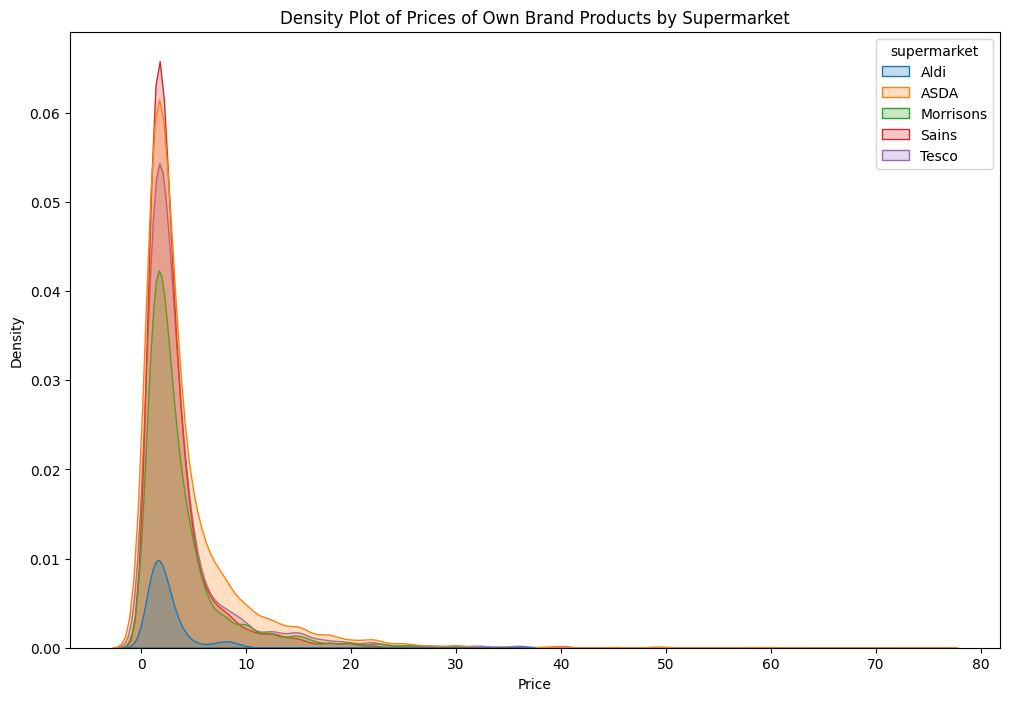

In [328]:
# Filter the dataset to only include own-brand products
own_brand_df = df[df['own_brand'] == True]

plt.figure(figsize=(12, 8))
sns.kdeplot(data=own_brand_df, x='price', hue='supermarket', fill=True)
plt.title('Density Plot of Prices of Own Brand Products by Supermarket')
plt.xlabel('Price')
plt.ylabel('Density')
plt.savefig('density_plot_own_brand_prices.png')
plt.show()

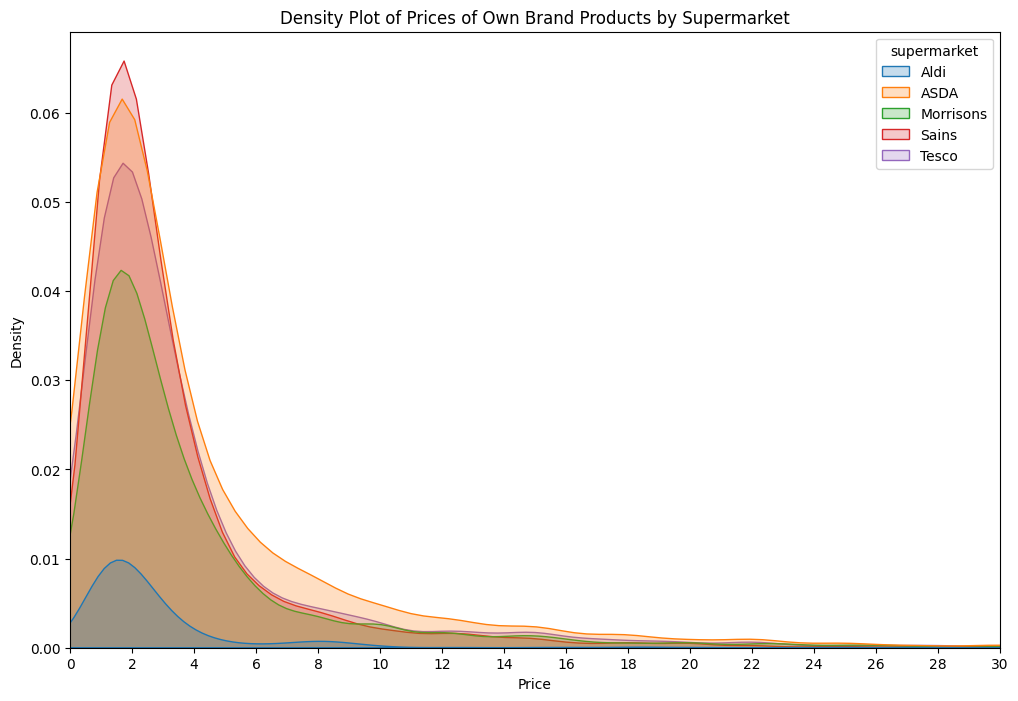

In [329]:
# Filter the dataset to only include own-brand products
own_brand_df = df[df['own_brand'] == True]

plt.figure(figsize=(12, 8))
sns.kdeplot(data=own_brand_df, x='price', hue='supermarket', fill=True)
plt.xlim(0, 30)
plt.xticks(ticks=range(0, 31, 2))
plt.title('Density Plot of Prices of Own Brand Products by Supermarket')
plt.xlabel('Price')
plt.ylabel('Density')
plt.savefig('density_plot_own_brand_prices.png')
plt.show()

As we can observe, Aldi has a slightly lower peak value for the prices of own-brand products, around £1.50, compared to approximately £2 for the other supermarkets. The upper boundary for Aldi's peak is about £11, while it extends to around £30 for the other supermarkets. These figures are not significantly different from the overall price distributions for each supermarket, indicating that own-brand products are not necessarily cheaper. In fact, in Aldi's case, they are slightly more expensive than other brand products, as shown in the distribution of prices for non-own-brand products below.

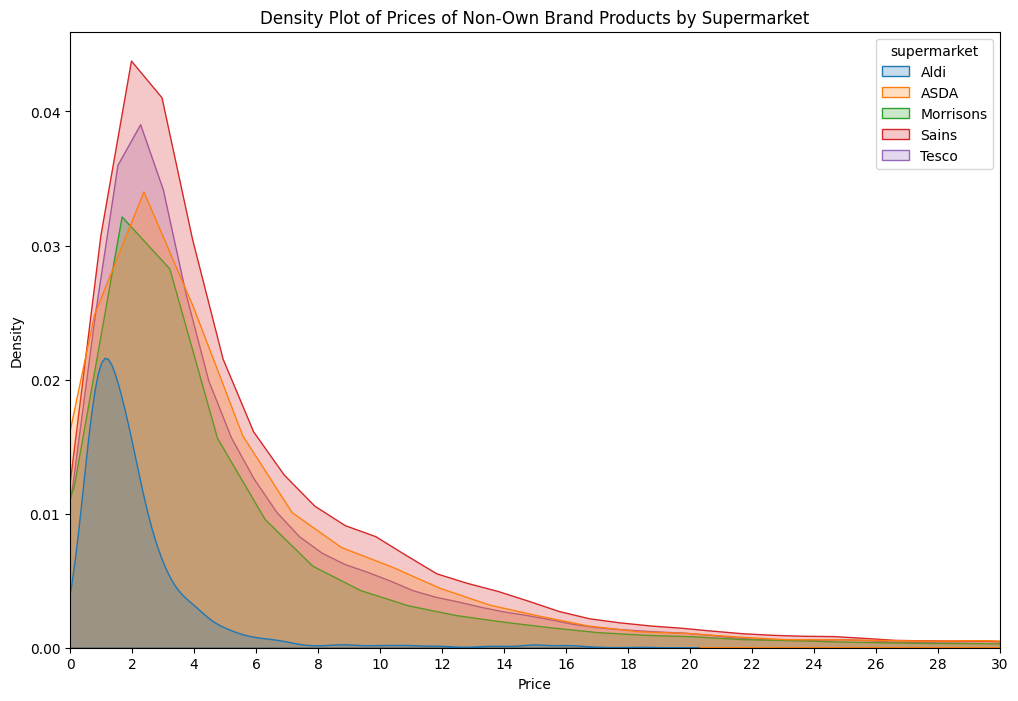

In [330]:
# Filter the dataset to only include own-brand products
own_brand_df = df[df['own_brand'] == False]

plt.figure(figsize=(12, 8))
sns.kdeplot(data=own_brand_df, x='price', hue='supermarket', fill=True)
plt.xlim(0, 30)
plt.xticks(ticks=range(0, 31, 2))
plt.title('Density Plot of Prices of Non-Own Brand Products by Supermarket')
plt.xlabel('Price')
plt.ylabel('Density')
plt.show()

This analysis suggests that all supermarkets offer a mix of cheap and premium own-brand products, with Aldi placing a stronger emphasis on premium own-brand offerings. However, the difference in peak values is not very significant, highlighting that the pricing strategy for own-brand products is relatively similar across supermarkets.

In [336]:
# Initialise an empty list to store the results
results = []

# List of supermarkets
supermarkets = df['supermarket'].unique()

# Calculate the percentage of own-brand products for each supermarket
for supermarket in supermarkets:
    total_products = df[df['supermarket'] == supermarket]['supermarket_total_products'].iloc[0]
    total_own_brand_products = df[df['supermarket'] == supermarket]['supermarket_total_own_brand_products'].iloc[0]
    percentage_own_brand = int((total_own_brand_products / total_products) * 100)
    percentage_not_own_brand = 100 - percentage_own_brand
    results.append({'supermarket': supermarket, 'percentage_own_brand': percentage_own_brand, 'percentage_not_own_brand': percentage_not_own_brand})

# Convert the results into a DataFrame
results_df = pd.DataFrame(results)

results_df

,supermarket,percentage_own_brand,percentage_not_own_brand
0,Aldi,0,100
1,ASDA,29,71
2,Morrisons,0,100
3,Sains,0,100
4,Tesco,0,100


Additionally, Aldi focuses less on own-brand products, which comprise only 16% of their total product range in the dataset. In comparison, own-brand products account for 29% at ASDA, 24% at Morrisons, 22% at Sainsbury's, and 26% at Tesco. This disparity suggests a potential correlation between a smaller own-brand product range and higher customer satisfaction. However, the difference is not substantial enough to conclusively attribute customer satisfaction to this factor, especially given the limitations of our dataset regarding customer satisfaction scores.

A more intriguing area to analyze is Aldi's strategy of selling private brands, in contrast to the well-known brands offered by traditional supermarkets. Anecdotal evidence suggests that this strategy eliminates the middleman and avoids the higher costs associated with purchasing well-known brands. 

To finish this section, we will have a look at the distribution of categories within own brand products.

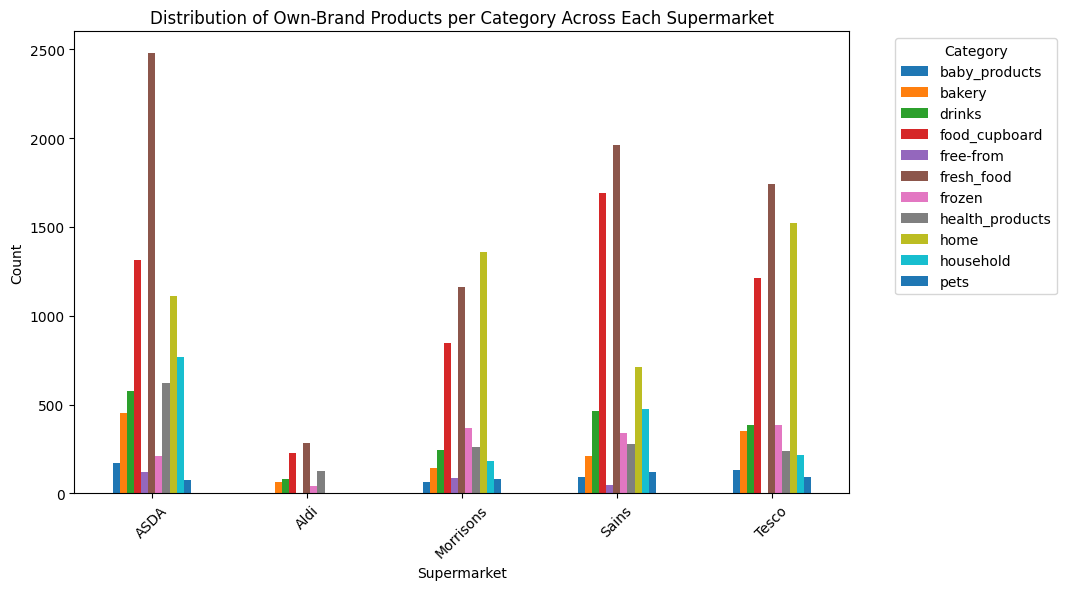

In [337]:
# Filter the dataset to only include own-brand products
own_brand_df = df[df['own_brand'] == True]

category_counts = own_brand_df.groupby(['supermarket', 'category']).size().unstack().fillna(0).astype(int)
category_counts.plot(kind='bar', stacked=False, figsize=(10, 6))
plt.title('Distribution of Own-Brand Products per Category Across Each Supermarket')
plt.xlabel('Supermarket')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig('group_bar_own_brand_category.png')
plt.show()

Aldi appears to be an outlier, selling own brand products in only 6 out of the 11 categories in the dataset: fresh food, food cupboard, health products, drinks, bakery, and frozen. Despite this limited range, Aldi, like other supermarkets, focuses on own brand fresh food products. The exception is Morrisons, which primarily sells own brand home products.

ASDA's emphasis on own brand fresh food products is disproportionately large compared to its other product categories. Own brand home products are also a significant focus for most supermarkets, except for Aldi, which, as previously mentioned, has no home products in the dataset.

Aldi's smaller distribution of categories for own brand products may be part of its strategy to maintain a smaller product range. From anecdotal evidence, this approach can lead to lower everyday prices and potentially higher customer satisfaction scores.

In [338]:
df.to_csv('supermarkets_cleaned.csv', index=False)

## 4.5: Conclusions & Further Work

### 1. Conclusions

The analysis of supermarket data reveals a complex relationship between product range, pricing strategy and customer satisfaction. While the findings suggest that lower prices, a smaller product range, a more limited own-brand selection and lower mean prices for own-brand products are associated with higher customer satisfaction, these results should be interpreted with caution due to the limited data points available for customer satisfaction metrics.

The case of Aldi, which demonstrates higher customer satisfaction despite having a narrower product range and lower prices, supports the notion that focusing on essential, high-demand items at competitive prices can be an effective strategy. However, the fact that Sainsbury's and Tesco also achieve relatively high customer satisfaction scores, despite offering a broader product range and higher own-brand prices, indicates that other factors beyond pricing and product range are influencing customer satisfaction. These could include factors such as store experience, customer service quality, brand perception or loyalty programmes, which were not captured in the dataset.

Given these findings, the primary recommendation is for supermarkets to carefully evaluate their product and pricing strategies, particularly in relation to their target customer segments. Traditional supermarkets might explore whether a more focused product offering, akin to Aldi's approach, could enhance customer satisfaction without sacrificing sales. However, this should be balanced against the potential benefits of a broader product range, as exemplified by Sainsbury's and Tesco.

Moreover, the limited scope of customer satisfaction data in this analysis highlights the need for further investigation. More granular data, such as product-level satisfaction ratings or feedback on specific store attributes, would allow for a deeper exploration of the causal relationships between pricing, product range and customer satisfaction. This could provide more actionable insights and help supermarkets refine their strategies to better align with customer expectations.

In conclusion, while the current analysis offers valuable insights into the relationship between product range, pricing and customer satisfaction, the results must be viewed within the context of the data's limitations. A more comprehensive approach, incorporating additional data sources and exploring other influencing factors, would be necessary to fully understand and optimise the drivers of customer satisfaction in the supermarket industry.

### 1. Further Work

To build on the analysis conducted in this chapter, several key areas should be explored further to deepen our understanding of the factors influencing customer satisfaction.

One immediate next step would be to expand the dataset by scraping data from additional supermarkets over an extended period. By including more competitors, we can make more comprehensive comparisons and potentially uncover new insights into the causal factors that affect customer satisfaction. This broader dataset would allow for a more robust analysis and could help validate the trends identified in the current study.

In addition to expanding the dataset, incorporating product reviews from supermarket websites, where available, would provide a more detailed metric for customer satisfaction. Although these reviews are specific to individual products, they could serve as a proxy for general satisfaction levels across entire supermarkets. Visualising this data, particularly through density plots, could offer valuable insights into how product-level satisfaction correlates with broader customer sentiment.

Furthermore, an analysis of the 'price per unit' column, which was not included in the current chapter due to time constraints, should be conducted. Visualising this data could reveal important pricing strategies that impact customer satisfaction, especially when combined with the existing analysis of overall prices and product ranges.

Access to more legitimate customer service metrics, such as the UK Customer Satisfaction Index (UKCSI), which unfortunately are unavailable, could also provide a more robust foundation for measuring customer satisfaction. Incorporating such metrics would allow us to validate our findings and explore multiple dimensions of customer satisfaction, leading to more nuanced insights.

Finally, a closer examination of outliers such as Sainsbury's and Tesco is necessary to understand why these supermarkets deviate from the general trends observed. Investigating factors such as customer loyalty programmes, in-store experiences or brand perception could provide insights that are crucial for refining our strategic recommendations.

In summary, expanding the dataset, incorporating product reviews, analysing price per unit, investigating outliers and, if available, adding legitimate customer service metrics are critical areas for further work. These efforts will enhance our understanding of the causal relationships identified and provide more actionable insights for improving customer satisfaction.